# crawling data

In [ ]:
'''
B1 : tạo 1 thư mục trống chứa file crawl dữ liệu. Giả sử thư mục này tên là MyFolder.

B2 : tải selenium bằng câu lệnh pip install selenium

B3 : tải Microsoft Edge driver. Để tải Edge driver, trước tiên ta mở edge browser -> vào Settings -> chọn About Microsoft Edge.
Đảm bảo Edge đã cập nhật phiên bản mới nhất. Ghi nhớ Version của edge browser. Sau đó, click vào link
https://developer.microsoft.com/en-us/microsoft-edge/tools/webdriver/
để tải phiên bản driver phù hợp.
Chọn mục Recent version, tìm phiên bản phù hợp và chọn x64 để tải về file zip. Giải nén để tạo file exe. Di chuyển
file exe vào thư mục MyFolder, đặt file exe cùng cấp với file crawl dữ liệu.

B4 : chạy file python với lệnh python 18_crawl_data.py (Lưu ý : Với những phiên bản selenium mới nhất sẽ không cần tham
số executable_path='msedgedriver.exe', xóa tham số này trong hàm đi sẽ chạy được)
'''

from selenium import webdriver
from time import sleep
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import os


bot = webdriver.Edge(executable_path='msedgedriver.exe')
bot.get('https://fptshop.com.vn/may-tinh-xach-tay?sort=ban-chay-nhat&trang=10')
bot.maximize_window()

# Lấy danh sách sản phẩm
products = WebDriverWait(bot, 20).until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, ".cdt-product")))

# Lặp qua từng phần tử
data = []
for i in range(0,len(products)):
     print(f'Đang crawl item thứ {i+1} ...')
     # Lấy kích thước màn hình (inch)
     try:
          screen = products[i].find_element(By.CSS_SELECTOR,'span[data-title="Màn hình"]').get_attribute('textContent')
          screen = float(re.search(r"[-+]?(?:\d*\.*\d+)", screen).group())
     except:
          screen = None
     # Lấy CPU
     try:
          cpu = products[i].find_element(By.CSS_SELECTOR,'span[data-title="CPU"]').get_attribute('textContent')
     except:
          cpu = None
     # Lấy RAM (GB)
     try:
          ram = products[i].find_element(By.CSS_SELECTOR,'span[data-title="RAM"]').get_attribute('textContent')
          ram = int(re.search(r"[-+]?(?:\d*\.*\d+)", ram).group())
     except:
          ram = None
     # Lấy dung lượng ổ cứng (GB)
     try:
          ssd = products[i].find_element(By.CSS_SELECTOR,'span[data-title="Ổ cứng"]').get_attribute('textContent')
          ssd = int(re.search(r"[-+]?(?:\d*\.*\d+)", ssd).group())
     except:
          ssd = None
     # Lấy card đồ họa
     try:
          gpu = products[i].find_element(By.CSS_SELECTOR,'span[data-title="Đồ họa"]').get_attribute('textContent')
          # gpu = re.search(r'\S+', gpu).group()
     except:
          gpu = None
     # Lấy trọng lượng (kg)
     try:
          weight = products[i].find_element(By.CSS_SELECTOR,'span[data-title="Trọng lượng"]').get_attribute('textContent')
          weight = float(re.search(r"[-+]?(?:\d*\.*\d+)", weight).group())
          if weight > 10: weight /= 1000
          name = products[i].find_element(By.CSS_SELECTOR,'.cdt-product__name').get_attribute('textContent')
          if 'Laptop' in name:
               name = name.replace('Laptop','')
          elif 'Máy tính xách tay' in name:
               name = name.replace('Máy tính xách tay','')
          else: pass
     except:
          weight = None
     # Lấy tên máy tính
     try:
          name = name.strip()
          name = re.search(r'\S+', name).group().lower()
     except:
          name = None
     # Lấy khuyến mãi (đồng)
     try:
          discount = products[i].find_element(By.CSS_SELECTOR,'.badge-primary').get_attribute('textContent').replace('.','')
          discount = int(re.search(r"[-+]?(?:\d*\.*\d+)", discount).group())
     except:
          discount = 0
     # Lấy giá (đồng)
     try:
          price = products[i].find_element(By.CSS_SELECTOR,'.progress').get_attribute('textContent').replace('.','')
          price = int(re.search(r"[-+]?(?:\d*\.*\d+)", price).group())
     except:
          price = products[i].find_element(By.CSS_SELECTOR,'.price').get_attribute('textContent').replace('.','')
          price = int(re.search(r"[-+]?(?:\d*\.*\d+)", price).group())

     # Click products
     click_item = products[i].find_element(By.CSS_SELECTOR,'.cdt-product__name')
     original_window = bot.current_window_handle
     click_item.click()
     new_window = bot.current_window_handle
     bot.switch_to.window(new_window)
     try:
          link = WebDriverWait(bot, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, ".re-link.js--open-modal")))
     except:
          bot.back()
          bot.switch_to.window(original_window)
          products = WebDriverWait(bot, 20).until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, ".cdt-product")))
          continue
     # Lấy thời gian bảo hành (tháng)
     try:
          warranty = bot.find_element(By.CSS_SELECTOR,'.l-pd-policy > .l-pd-policy__item:nth-child(2) > p').get_attribute('textContent')
          warranty = int(re.search(r"[-+]?(?:\d*\.*\d+)", warranty).group())
     except:
          warranty = None
     # Lấy FGold (dùng để đổi Voucher khi thanh toán)
     try:
          fgold = bot.find_element(By.CSS_SELECTOR,'.btn-loyalty.tooltip.tooltip-right.tooltip-dark > strong').get_attribute('textContent')
          fgold = float(re.search(r"[-+]?(?:\d*\.*\d+)", fgold).group())
     except:
          fgold = 0
     # Lấy Trả góp (đồng/tháng)
     try:
          installment = bot.find_element(By.CSS_SELECTOR,'.st-price > .st-price__right span:nth-child(2) strong').get_attribute('textContent')
          installment = int(float(re.search(r"[-+]?(?:\d*\.*\d+)", installment).group()) * 1000000)
     except:
          installment = 0
     # # Lấy số lượng đánh giá
     try:
          evaluation = bot.find_element(By.CSS_SELECTOR,'.st-rating__link > a:nth-child(1)').get_attribute('textContent')
          evaluation = int(re.search(r"[-+]?(?:\d*\.*\d+)", evaluation).group())
     except:
          evaluation = 0
     # Lấy số lượng hỏi đáp
     try:
          answer = bot.find_element(By.CSS_SELECTOR,'.st-rating__link > a:last-child').get_attribute('textContent')
          answer = int(re.search(r"[-+]?(?:\d*\.*\d+)", answer).group())
     except:
          answer = 0
     # Lấy số sao
     try:
          star = bot.find_elements(By.CSS_SELECTOR,'.st-rating__star > li span.icon-star.fill')
          star = len(star)
     except:
          star = 0

     # Click vào link để lấy thông số kỹ thuật
     link.click()
     # Lấy hệ điều hành
     try:
          os = WebDriverWait(bot, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, ".c-modal__row:nth-last-child(2) > .st-table tr:nth-child(1) td:last-child"))).get_attribute('textContent').lower()
     except:
          os = None

     # Phần bổ sung
     # Lấy phần Thiết kế (2): kích thước (mm), màu sắc
     # Lấy phần Bộ xử lý (5): hãng cpu, loại cpu, tốc độ cpu (GHz), số nhân, số luồng
     # Lấy phần RAM (4): loại RAM, tốc độ RAM (MHz), số khe cắm rời, số ram onboard
     # Lấy màn hình (5): công nghệ màn hình, độ phân giải, loại màn hình,tần số quét, tấm nền, độ phủ màu
     # Lấy âm thanh (1): số lượng loa
     # Lấy bàn phím (3): kiểu bàn phím, bàn phím số, đèn bàn phím
     # Lấy sạc (2): loại pin, power supply
     size = color = cpu_branch = cpu_type = cpu_speed = cpu_core = cpu_thread = \
     ram_type = ram_speed = ram_track = ram_onboard = screen_tech = screen_resolution = screen_scan = \
     screen_plate = screen_coverage = screen_type = speaker = keyboard_type = keyboard_number = keyboard_lamp = \
     battery_type = battery_supply = None

     fields = bot.find_elements(By.CSS_SELECTOR,'.c-modal__content > .c-modal__row')
     for field in fields:
          title_element = field.find_element(By.CSS_SELECTOR,'.st-table-title')
          title = title_element.get_attribute('textContent')
          if title == 'Thông tin hàng hóa':
               continue
          # Lấy phần Thiết kế (2): kích thước (mm), màu sắc
          elif title == 'Thiết kế & Trọng lượng':
               rows = field.find_elements(By.CSS_SELECTOR, 'table:nth-child(2) > tbody tr')
               for row in rows:
                    title_td = row.find_element(By.CSS_SELECTOR, 'td:nth-child(1)')
                    text_td = title_td.get_attribute('textContent')
                    if text_td == 'Kích thước':
                         try:
                              size = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                         except:
                              size = None
                    elif text_td == 'Màu sắc':
                         try:
                              color = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                         except:
                              color = None
                    else: continue
          # Lấy phần Bộ xử lý (5): hãng cpu, loại cpu, tốc độ cpu (GHz), số nhân, số luồng
          elif title == 'Bộ xử lý':
               rows = field.find_elements(By.CSS_SELECTOR, 'table > tbody tr')
               for row in rows:
                    title_td = row.find_element(By.CSS_SELECTOR, 'td:nth-child(1)')
                    text_td = title_td.get_attribute('textContent')
                    if text_td == 'Hãng CPU':
                         try:
                              cpu_branch = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                         except:
                              cpu_branch = None
                    elif text_td == 'Loại CPU':
                         try:
                              cpu_type = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                         except:
                              cpu_type = None
                    elif text_td == 'Tốc độ CPU':
                         try:
                              cpu_speed = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                              cpu_speed = float(re.search(r"[-+]?(?:\d*\.*\d+)", cpu_speed).group())
                         except:
                              cpu_speed = None
                    elif text_td == 'Số nhân':
                         try:
                              cpu_core = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                              cpu_core = int(re.search(r"[-+]?(?:\d*\.*\d+)", cpu_core).group())
                         except:
                              cpu_core = None
                    elif text_td == 'Số luồng':
                         try:
                              cpu_thread = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                              cpu_thread = int(re.search(r"[-+]?(?:\d*\.*\d+)", cpu_thread).group())
                         except:
                              cpu_thread = None
                    else: continue
          # Lấy phần RAM (4): loại RAM, tốc độ RAM (MHz), số khe cắm rời, số ram onboard
          elif title == 'RAM':
               rows = field.find_elements(By.CSS_SELECTOR, 'table > tbody tr')
               for row in rows:
                    title_td = row.find_element(By.CSS_SELECTOR, 'td:nth-child(1)')
                    text_td = title_td.get_attribute('textContent')
                    if text_td == 'Loại RAM':
                         try:
                              ram_type = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                         except:
                              ram_type = None
                    elif text_td == 'Tốc độ RAM':
                         try:
                              ram_speed = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                         except:
                              ram_speed = None
                    elif text_td == 'Số khe cắm rời':
                         try:
                              ram_track = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                         except:
                              ram_track = None
                    elif text_td == 'Số RAM onboard':
                         try:
                              ram_onboard = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                         except:
                              ram_onboard = None
                    else: continue
          # Lấy màn hình (5): công nghệ màn hình, độ phân giải,  tần số quét, tấm nền, độ phủ màu
          elif title == 'Màn hình':
               rows = field.find_elements(By.CSS_SELECTOR, 'table > tbody tr')
               for row in rows:
                    title_td = row.find_element(By.CSS_SELECTOR, 'td:nth-child(1)')
                    text_td = title_td.get_attribute('textContent')
                    if text_td == 'Công nghệ màn hình':
                         try:
                              screen_tech = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                         except:
                              screen_tech = None
                    elif text_td == 'Độ phân giải':
                         try:
                              screen_resolution = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                         except:
                              screen_resolution = None
                    elif text_td == 'Tần số quét':
                         try:
                              screen_scan = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                         except:
                              screen_scan = None
                    elif text_td == 'Loại màn hình':
                         try:
                              screen_type = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                         except:
                              screen_type = None
                    elif text_td == 'Tấm nền':
                         try:
                              screen_plate = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                         except:
                              screen_plate = None
                    elif text_td == 'Độ phủ màu':
                         try:
                              screen_coverage = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                         except:
                              screen_coverage = None
                    else: continue
          # Lấy âm thanh (1): số lượng loa
          elif title == 'Âm thanh':
               rows = field.find_elements(By.CSS_SELECTOR, 'table > tbody tr')
               for row in rows:
                    title_td = row.find_element(By.CSS_SELECTOR, 'td:nth-child(1)')
                    text_td = title_td.get_attribute('textContent')
                    if text_td == 'Số lượng loa':
                         try:
                             speaker = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                         except:
                             speaker = None
                    else: continue
          # Lấy bàn phím (3): kiểu bàn phím, bàn phím số, đèn bàn phím
          elif title == 'Bàn phím & TouchPad':
               rows = field.find_elements(By.CSS_SELECTOR, 'table > tbody tr')
               for row in rows:
                    title_td = row.find_element(By.CSS_SELECTOR, 'td:nth-child(1)')
                    text_td = title_td.get_attribute('textContent')
                    if text_td == 'Kiểu bàn phím':
                         try:
                              keyboard_type = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                         except:
                              keyboard_type = None
                    elif text_td == 'Bàn phím số':
                         try:
                              keyboard_number = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                         except:
                              keyboard_number = None
                    elif text_td == 'Đèn bàn phím':
                         try:
                              keyboard_lamp = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                         except:
                              keyboard_lamp = None
                    else: continue
          # Lấy sạc (2): loại pin, power supply
          elif title == 'Thông tin pin & Sạc':
               rows = field.find_elements(By.CSS_SELECTOR, 'table > tbody tr')
               for row in rows:
                    title_td = row.find_element(By.CSS_SELECTOR, 'td:nth-child(1)')
                    text_td = title_td.get_attribute('textContent')
                    if text_td == 'Loại PIN':
                         try:
                              battery_type = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                         except:
                              battery_type = None
                    elif text_td == 'Power Supply':
                         try:
                              battery_supply = row.find_element(By.CSS_SELECTOR, 'td:nth-child(2)').get_attribute('textContent')
                         except:
                              battery_supply = None
                    else: continue
          else: continue

     data.append({'branch': name, 'screen': screen, 'CPU': cpu, 'RAM': ram, 'memory': ssd, 'graphic card': gpu, 'weight': weight, 'discount': discount,
                  'warranty': warranty, 'fgold': fgold, 'installment': installment,
                  'evaluation': evaluation, 'answer': answer, 'star': star ,
                  'size': size, 'color': color, 'cpu_branch': cpu_branch, 'cpu_type': cpu_type,
                   'cpu_speed': cpu_speed, 'cpu_core': cpu_core, 'cpu_thread': cpu_thread ,
                    'ram_type': ram_type, 'ram_speed': ram_speed, 'ram_track': ram_track,
                    'ram_onboard': ram_onboard , 'screen_tech': screen_tech, 'screen_resolution': screen_resolution,
                    'screen_plate': screen_plate, 'screen_scan': screen_scan, 'screen_coverage': screen_coverage,
                    'screen_type': screen_type,'speaker': speaker, 'keyboard_type': keyboard_type, 'keyboard_number': keyboard_number,
                    'keyboard_lamp': keyboard_lamp, 'battery_type': battery_type, 'battery_supply': battery_supply ,'os': os, 'price': price })
     bot.back()
     bot.switch_to.window(original_window)
     products = WebDriverWait(bot, 20).until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, ".cdt-product")))

df = pd.DataFrame.from_dict(data)
df.to_csv('data_ds105.csv', index=False)

# **1. Load dữ liệu**

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import statistics as stt
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import re
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows

In [ ]:
data=pd.read_csv('data_ds105.csv')
data

branch  screen      CPU  RAM  memory                       graphic card  weight  discount  \
0    asus       15.6    Core i5  16   512     NVIDIA GeForce RTX 2050 4GB        2.300   3000000    
1    msi        15.6    Core i5  16   512     NVIDIA GeForce RTX 4050 6GB GDDR6  1.860   1500000    
2    asus       15.6    Core i5  16   512     NVIDIA GeForce RTX 3050 4GB        2.200   5000000    
3    lenovo     15.6    Ryzen 5  8    512     NVIDIA GeForce RTX 4050 6GB GDDR6  2.320   4000000    
4    acer       15.6    Core i5  8    512     Intel UHD Graphics                 2.100   3000000    
5    hp         14.0    Ryzen 5  8    256     AMD Radeon Graphics                1.360   1900000    
6    asus       14.0    Ryzen 5  16   512     Intel UHD Graphics                 1.500   2300000    
7    lenovo     15.6    Ryzen 5  16   512     AMD Radeon Graphics                1.580   1700000    
8    hp         14.0    Ryzen 5  16   512     AMD Radeon Graphics                1.400   1200000    
9    asus       14.0    Ryzen 5  16   512     AMD Radeon Graphics                1.300   2000000    
10   lenovo     15.6    Core i5  16   512     Intel Iris Xe Graphics             1.650   1800000    
11   hp         14.0    Core i5  16   512     Intel Iris Xe Graphics             1.410   3000000    
12   dell       15.6    Core i5  16   512     NVIDIA GeForce MX550 2GB           1.660   2000000    
13   msi        15.6    Core i5  16   512     NVIDIA GeForce RTX 3050 4GB        1.860   1700000    
14   asus       15.6    Ryzen 3  8    256     Intel UHD Graphics                 1.800   2500000    
15   msi        15.0    Core i7  8    512     NVIDIA GeForce RTX 3050 4GB        1.860   2000000    
16   lenovo     14.0    Core i5  16   512     Intel UHD Graphics                 1.370   1500000    
17   asus       15.6    Core i5  16   512     Intel UHD Graphics                 1.700   2500000    
18   asus       14.0    Core i3  8    256     Intel UHD Graphics                 1.600   2000000    
19   msi        15.6    Core i5  8    512     NVIDIA GeForce GTX 1650 4GB        1.860   2000000    
20   dell       15.6    Core i5  8    256     Intel Iris Xe Graphics             1.900   3600000    
21   lenovo     15.6    Core i7  16   512     Intel Iris Xe Graphics             1.630   1300000    
22   asus       15.6    Ryzen 5  16   512     Intel Iris Xe Graphics             1.700   2300000    
23   hp         14.0    Core i5  8    512     Intel Iris Xe Graphics             1.410   3400000    
24   dell       15.6    Core i7  16   512     NVIDIA GeForce MX550 2GB           1.650   3500000    
25   asus       14.0    Core i5  8    512     Intel UHD Graphics                 1.600   4500000    
26   hp         14.0    Ryzen 3  8    256     AMD Radeon Graphics                1.400   2300000    
27   acer       15.6    Core i3  8    256     Intel UHD Graphics                 1.700   1300000    
28   acer       14.0    Ryzen 5  16   512     AMD Radeon Graphics                1.190   6000000    
29   hp         14.0    Ryzen 5  8    256     AMD Radeon Graphics                1.470   2600000    
30   asus       15.6    Core i5  8    512     NVIDIA GeForce RTX 3050 4GB        2.300   4000000    
31   hp         14.0    Ryzen 5  8    512     AMD Radeon Graphics                1.400   1400000    
32   msi        14.0    Ryzen 7  8    512     AMD Radeon Graphics                1.400   1500000    
33   acer       15.6    Core i5  8    512     NVIDIA GeForce RTX 3050 4GB        2.500   6500000    
34   asus       15.6    Ryzen 7  8    512     NVIDIA GeForce RTX 4050 6GB GDDR6  2.200   4500000    
35   acer       15.6    Core i5  8    512     NVIDIA GeForce RTX 3050 4GB        2.500   6000000    
36   hp         15.6    Core i5  16   512     Intel UHD Graphics                 1.680   1700000    
37   lenovo     14.0    Core i5  16   512     Intel Iris Xe Graphics             1.460   1500000    
38   hp         15.6    Core i3  8    256     Intel UHD Graphics     

In [ ]:
# In ra 10 dòng đầu
data.head(10)

branch  screen      CPU  RAM  memory                       graphic card  weight  discount  \
0  asus    15.6    Core i5  16   512     NVIDIA GeForce RTX 2050 4GB        2.30    3000000    
1  msi     15.6    Core i5  16   512     NVIDIA GeForce RTX 4050 6GB GDDR6  1.86    1500000    
2  asus    15.6    Core i5  16   512     NVIDIA GeForce RTX 3050 4GB        2.20    5000000    
3  lenovo  15.6    Ryzen 5  8    512     NVIDIA GeForce RTX 4050 6GB GDDR6  2.32    4000000    
4  acer    15.6    Core i5  8    512     Intel UHD Graphics                 2.10    3000000    
5  hp      14.0    Ryzen 5  8    256     AMD Radeon Graphics                1.36    1900000    
6  asus    14.0    Ryzen 5  16   512     Intel UHD Graphics                 1.50    2300000    
7  lenovo  15.6    Ryzen 5  16   512     AMD Radeon Graphics                1.58    1700000    
8  hp      14.0    Ryzen 5  16   512     AMD Radeon Graphics                1.40    1200000    
9  asus    14.0    Ryzen 5  16   512     AMD Radeon Graphics                1.30    2000000    

   warranty  fgold  installment  evaluation  answer  star                          size color  \
0  24        4.747  1659000      65          106     5     359 x 256 x 22.8 ~ 24.3 mm    Đen    
1  12        5.497  1860000      111         76      5     359 x  254 x 21.7 mm          Đen    
2  24        5.122  1900000      91          116     4     35.4 x 25.1 x 2.24 ~ 2.49 cm  Xám    
3  24        5.747  2101000      15          48      4     359.6 x 266.4 x 21.8 mm       Xám    
4  12        3.622  1329000      18          131     5     362.3 x 237.4  x 19.9 mm      Đen    
5  12        3.322  1040000      16          23      4     32.4 x 21.5 x 1.79 cm         Bạc    
6  24        4.147  1498000      20          47      5     31.32 x 22.76 x 1.89 cm       Bạc    
7  24        3.247  1056000      0           21      5     360.2 x 236 x 17.9 mm         Xám    
8  12        3.257  1233000      36          62      5     32.37 x 21.5 x 1.79 cm        Bạc    
9  24        3.247  1217000      74          128     4     32.45 x 21.39 x 1.79 cm       Đen    

  cpu_branch cpu_type  cpu_speed  cpu_core  cpu_thread ram_type ram_speed ram_track ram_onboard  \
0  Intel      11400H   2.7        6.0      NaN          DDR4     3200 MHz  2         0            
1  Intel      12450H   2.0        8.0       12.0        DDR4     3200 MHz  2         0            
2  Intel      12500H   2.5        12.0      16.0        DDR4     3200 MHz  2         0            
3  AMD        7535HS   3.3        6.0       12.0        DDR5     4800 MHz  1         1            
4  Intel      12450H   3.3        8.0       12.0        DDR4     3200 MHz  2         0            
5  AMD        7520U    4.3       NaN       NaN          NaN      NaN       0         1            
6  AMD        7530U    2.0       NaN       NaN          NaN      NaN       0         1            
7  AMD        5500U    2.1        6.0       12.0        DDR4     3200 MHz  0         2            
8  AMD        7520U    2.8        4.0       8.0         LPDDR5   5500 MHz  0         1            
9  AMD        7520U    2.8        4.0       8.0         LPDDR5   5500 MHz  Không     Có           

                  screen_tech   screen_resolution screen_plate screen_scan screen_coverage  \
0  Anti-Glare                  1920 x 1080 Pixels  IPS          144         NaN              
1  IPS FHD                     1920 x 1080 Pixels  IPS          144         45% NTSC         
2  Anti - Glare                1920 x 1080 Pixels  IPS          144         63% sRGB         
3  Anti - Glare                1920 x 1080 Pixels  IPS          120         45% NTSC         
4  Acer ComfyView LED-backlit  1920 x 1080 Pixels  IPS          60          NaN              
5  LCD                         1920 x 1080 Pixels  IPS          60          NaN              
6  LED Backlit                 1920 x 1200 Pixels  IPS          60          NaN              
7  FHD                         1920 

In [ ]:
# giá trị của sample đầu tiên
data.iloc[1]

branch               msi                              
screen               15.6                             
CPU                  Core i5                          
RAM                  16                               
memory               512                              
graphic card         NVIDIA GeForce RTX 4050 6GB GDDR6
weight               1.86                             
discount             1500000                          
warranty             12                               
fgold                5.497                            
installment          1860000                          
evaluation           111                              
answer               76                               
star                 5                                
size                 359 x  254 x 21.7 mm             
color                Đen                              
cpu_branch           Intel                            
cpu_type             12450H                           
cpu_speed 

# **2. Tiền xử lý**

**a) Kiểm tra kiểu dữ liệu**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   branch             257 non-null    object 
 1   screen             257 non-null    float64
 2   CPU                257 non-null    object 
 3   RAM                257 non-null    int64  
 4   memory             257 non-null    int64  
 5   graphic card       228 non-null    object 
 6   weight             257 non-null    float64
 7   discount           257 non-null    int64  
 8   warranty           257 non-null    int64  
 9   fgold              257 non-null    float64
 10  installment        257 non-null    int64  
 11  evaluation         257 non-null    int64  
 12  answer             257 non-null    int64  
 13  star               257 non-null    int64  
 14  size               256 non-null    object 
 15  color              257 non-null    object 
 16  cpu_branch         257 non

Nhận xét : data type đã phù hợp

**b) Xử lý null**

In [ ]:
data.isnull().sum()

branch               0  
screen               0  
CPU                  0  
RAM                  0  
memory               0  
graphic card         29 
weight               0  
discount             0  
warranty             0  
fgold                0  
installment          0  
evaluation           0  
answer               0  
star                 0  
size                 1  
color                0  
cpu_branch           0  
cpu_type             3  
cpu_speed            19 
cpu_core             72 
cpu_thread           81 
ram_type             21 
ram_speed            64 
ram_track            0  
ram_onboard          1  
screen_tech          1  
screen_resolution    0  
screen_plate         3  
screen_scan          10 
screen_coverage      134
screen_type          120
speaker              147
keyboard_type        0  
keyboard_number      1  
keyboard_lamp        1  
battery_type         140
battery_supply       122
os                   0  
price                0  
dtype: int64

In [ ]:
data.replace(to_replace=['?','??','.','..','','_','nan','Na','NULL','null','not','Not'], value= np.nan, inplace=True)

In [ ]:
# Tỉ lệ số dữ liệu bị khuyết
sum_null = data.isnull().sum().sum()
rate_null = sum_null/(data.shape[0]*data.shape[1])*100
print('Tỉ lệ dữ liệu bị khuyết giá trị: %.2f'%(rate_null),'%')
data.isnull().sum().sort_values(ascending=False).to_frame()

Tỉ lệ dữ liệu bị khuyết giá trị: 9.68 %


0
speaker            147
battery_type       140
screen_coverage    134
battery_supply     122
screen_type        120
cpu_thread         81 
cpu_core           72 
ram_speed          64 
graphic card       29 
ram_type           21 
cpu_speed          19 
screen_scan        10 
screen_plate       3  
cpu_type           3  
keyboard_number    1  
keyboard_lamp      1  
size               1  
screen_tech        1  
ram_onboard        1  
keyboard_type      0  
ram_track          0  
screen_resolution  0  
os                 0  
branch             0  
screen             0  
cpu_branch         0  
color              0  
star               0  
answer             0  
evaluation         0  
installment        0  
fgold              0  
warranty           0  
discount           0  
weight             0  
memory             0  
RAM                0  
CPU                0  
price              0

In [ ]:
# Chia dữ liệu ra làm 2 dataframe chỉ gồm các thuộc tính liên tục hoặc phân loại
data_numeric=data.select_dtypes(exclude=object)
data_cate=data.select_dtypes(include=object)
data_cate.info()
data_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   branch             257 non-null    object
 1   CPU                257 non-null    object
 2   graphic card       228 non-null    object
 3   size               256 non-null    object
 4   color              257 non-null    object
 5   cpu_branch         257 non-null    object
 6   cpu_type           254 non-null    object
 7   ram_type           236 non-null    object
 8   ram_speed          193 non-null    object
 9   ram_track          257 non-null    object
 10  ram_onboard        256 non-null    object
 11  screen_tech        256 non-null    object
 12  screen_resolution  257 non-null    object
 13  screen_plate       254 non-null    object
 14  screen_scan        247 non-null    object
 15  screen_coverage    123 non-null    object
 16  screen_type        137 non-null    object
 1

<Figure size 1000x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, '% Missing Values for Each Column')

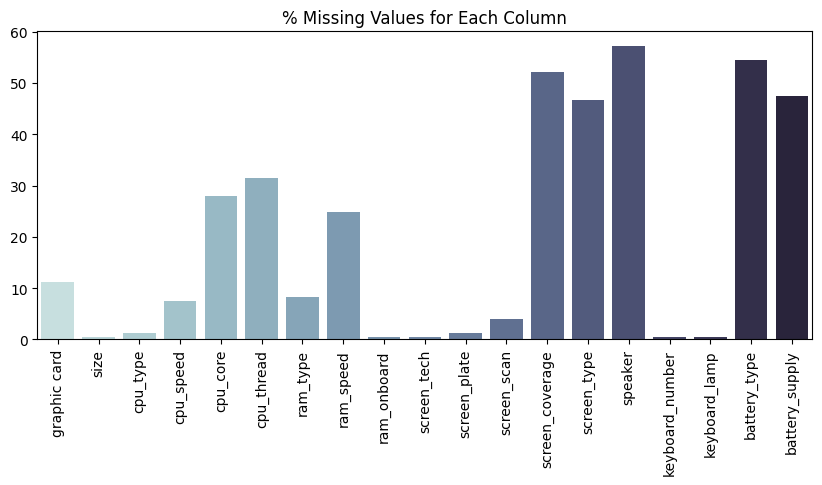

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Tính tỷ lệ giá trị bị khuyết cho từng cột
missing_percentage = (data.isna().sum() / len(data.index)) * 100

# Lọc ra những cột có tỷ lệ giá trị bị khuyết lớn hơn 0
missing_columns = missing_percentage[missing_percentage > 0]

# Tạo biểu đồ chỉ với những cột có giá trị bị khuyết
plt.figure(figsize=(10, 4))
sns.barplot(x=missing_columns.index, y=missing_columns, palette='ch:start=.2,rot=-.3')
plt.tick_params(axis='x', rotation=90)
plt.title('% Missing Values for Each Column')
plt.show()

**Xóa các cột có tỉ lệ khuyết cáo hơn 20%**

In [ ]:
# Tính tỷ lệ giá trị khuyết của từng cột
missing_values_ratio = (data.isnull().mean() * 100).round(2)

# Xác định các cột có tỷ lệ giá trị khuyết lớn hơn 20%
columns_to_drop = missing_values_ratio[missing_values_ratio > 20].index

# Xóa các cột có tỷ lệ giá trị khuyết lớn hơn 20%
data_cleaned = data.drop(columns=columns_to_drop)

In [ ]:
data_c=data_cleaned.copy()

In [ ]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   branch             257 non-null    object 
 1   screen             257 non-null    float64
 2   CPU                257 non-null    object 
 3   RAM                257 non-null    int64  
 4   memory             257 non-null    int64  
 5   graphic card       228 non-null    object 
 6   weight             257 non-null    float64
 7   discount           257 non-null    int64  
 8   warranty           257 non-null    int64  
 9   fgold              257 non-null    float64
 10  installment        257 non-null    int64  
 11  evaluation         257 non-null    int64  
 12  answer             257 non-null    int64  
 13  star               257 non-null    int64  
 14  size               256 non-null    object 
 15  color              257 non-null    object 
 16  cpu_branch         257 non

**Điền khuyết dữ liệu số**

In [ ]:
data_c.sort_values(['cpu_type', 'branch'], inplace=True)
def handle_missing_numeric (data_c):
    # Điền missing bằng phương pháp KNN với neighbors=5
    data_c=data_c.reset_index(drop=True) # Reset index
    data_numeric=data_c.select_dtypes(exclude=object).drop(columns=['price']) # Lựa chọn các thuộc tính số

    from sklearn.impute import KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    data_numeric = pd.DataFrame(imputer.fit_transform(data_numeric),columns = data_numeric.columns)

    for i in data_c.select_dtypes(exclude=object).drop(columns=['price']):
        data_c[i].update(data_numeric[i]) # update dữ liệu sau khi được điền
    return data_c

In [ ]:
data_c=handle_missing_numeric(data_c)

In [ ]:
# Vòng lặp để kiểm tra từng cột và điền giá trị thiếu bằng giá trị trước đó
for column in data_c.columns:
    if data_c[column].isnull().any():  # Kiểm tra xem cột có giá trị NaN hay không
        data_c[column].fillna(method='ffill', inplace=True)


In [ ]:
data_cc=data_c.copy()

In [ ]:
data_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   branch             257 non-null    object 
 1   screen             257 non-null    float64
 2   CPU                257 non-null    object 
 3   RAM                257 non-null    int64  
 4   memory             257 non-null    int64  
 5   graphic card       257 non-null    object 
 6   weight             257 non-null    float64
 7   discount           257 non-null    int64  
 8   warranty           257 non-null    int64  
 9   fgold              257 non-null    float64
 10  installment        257 non-null    int64  
 11  evaluation         257 non-null    int64  
 12  answer             257 non-null    int64  
 13  star               257 non-null    int64  
 14  size               257 non-null    object 
 15  color              257 non-null    object 
 16  cpu_branch         257 non

**Xử lý dữ liệu cột size**

In [ ]:
import re
#tách cột size thành 3 cột
def extract_and_adjust_dimensions(row):
    # Replace commas with dots
    row = row.replace(',', '.')

    # Use regular expression to extract three numbers and the unit
    matches = re.findall(r'(\d+(\.\d+)?)\s*([a-zA-Z]+)?', row)
    print(matches)
    # If at least three matches are found
    if len(matches) >= 3:
        # Sort the numbers in descending order
        numbers = sorted([float(matches[0][0]), float(matches[1][0]), float(matches[2][0])], reverse=True)
        return pd.Series([numbers[0], numbers[1], numbers[2]])
    else:
        return pd.Series([None, None, None])
data_cc[['width', 'length', 'height']] = data_cc['size'].apply(extract_and_adjust_dimensions)
print(data_cc[['size', 'width', 'length', 'height']])

[('31.26', '.26', 'x'), ('22.12', '.12', 'x'), ('1.55', '.55', 'cm')]
[('363.4', '.4', 'x'), ('250.5', '.5', 'x'), ('19.95', '.95', 'mm')]
[('1.55', '.55', 'x'), ('31.26', '.26', 'x'), ('22.12', '.12', 'cm')]
[('325.4', '.4', 'x'), ('216.0', '.0', 'x'), ('19.9', '.9', 'cm')]
[('359.0', '.0', 'x'), ('235.0', '.0', 'x'), ('17.9', '.9', 'mm')]
[('360', '', 'x'), ('235', '', 'x'), ('19.9', '.9', 'mm')]
[('35.85', '.85', 'x'), ('24.2', '.2', 'x'), ('1.79', '.79', 'cm')]
[('35.85', '.85', 'x'), ('24.2', '.2', 'x'), ('1.79', '.79', 'cm')]
[('32.4', '.4', 'x'), ('22.5', '.5', 'x'), ('1.79', '.79', 'cm')]
[('319.9', '.9', ''), ('223', '', ''), ('19.35', '.35', 'mm')]
[('367.8', '.8', ''), ('236.1', '.1', ''), ('18.9', '.9', '')]
[('18.9', '.9', 'x'), ('368', '', 'x'), ('235', '', 'mm')]
[('15.9', '.9', 'x'), ('322.8', '.8', 'x'), ('212.2', '.2', 'mm')]
[('328', '', 'x'), ('222.9', '.9', 'x'), ('17.9', '.9', 'mm')]
[('363.4', '.4', 'x'), ('247.5', '.5', 'x'), ('19.9', '.9', 'mm')]
[('363.4', '.4

In [ ]:
# chuyển hết về giá trị mm
for i in range(len(data_cc)):
  if   data_cc['height'][i] <  8.0:
       data_cc['height'][i]=data_cc['height'][i]*10.0
       data_cc['length'][i]=data_cc['length'][i]*10.0
       data_cc['width'][i]=data_cc['width'][i]*10.0
for i in range(len(data_cc)):
  if   data_cc['width'][i] > 1000.0:
       data_cc['length'][i]=data_cc['length'][i]/10.0
       data_cc['width'][i]=data_cc['width'][i]/10.0
for i in range(len(data_cc)):
  if   data_cc['width'][i] > 500.0:
       a = data_cc['length'][i]
       data_cc['length'][i]=data_cc['width'][i]
       data_cc['width'][i]=a

In [ ]:
print(data_cc[['size', 'width', 'length', 'height']])

                                                           size   width  length  height
0    31.26 x 22.12 x 1.55 cm                                     312.60  221.20  15.50 
1    363.4 x 250.5 x 19.95 mm                                    363.40  250.50  19.95 
2    1,55 x 31,26 x 22,12 cm                                     312.60  221.20  15.50 
3    325.4 x 216.0 x 19.9 cm                                     325.40  216.00  19.90 
4    359.0 x 235.0 x 17.9 mm                                     359.00  235.00  17.90 
5    360 x 235 x 19.9 mm                                         360.00  235.00  19.90 
6    35.85 x 24.2 x 1.79 cm                                      358.50  242.00  17.90 
7    35.85 x 24.2 x 1.79 cm                                      358.50  242.00  17.90 
8    32.4 x 22.5 x 1.79 cm                                       324.00  225.00  17.90 
9    319.9 * 223 * 19.35 mm                                      319.90  223.00  19.35 
10   367.8 (W) x 236.1 (D) x 18.

In [ ]:
# Đổi tên cột branch -> brand
data_cc_replaced = data_cc.rename(columns={'branch': 'brand'})

In [ ]:
# Thực hiện các thay thế
data_cc_replaced['os'] = data_cc_replaced['os'].replace('không', 'windows')
data_cc_replaced['os'] = data_cc_replaced['os'].replace('window phone', 'windows')
data_cc_replaced['screen_scan'] = data_cc_replaced['screen_scan'].replace('60  Màn hình chính:', '60')
data_cc_replaced['screen_scan'] = data_cc_replaced['screen_scan'].replace('60 Hz', '60')
data_cc_replaced['screen_scan'] = data_cc_replaced['screen_scan'].replace('144  Màn hình chính:', '144')
data_cc_replaced['screen_scan'] = data_cc_replaced['screen_scan'].replace('165  Màn hình chính:', '165')
data_cc_replaced['screen_scan'] = data_cc_replaced['screen_scan'].replace('0', '60')
data_cc_replaced['screen_scan'] = data_cc_replaced['screen_scan'].replace('4.7', '60')
data_cc_replaced['screen_scan'] = data_cc_replaced['screen_scan'].replace('Hãng không công bố', '60')
data_cc_replaced.at[58, 'cpu_speed'] = '4.3'
data_cc_replaced['keyboard_lamp'] = data_cc_replaced['keyboard_lamp'].replace('Đang cập nhật', 'Không')
data_cc_replaced['ram_track'] = data_cc_replaced['ram_track'].replace('Không', '0')
# Fill remaining NaN values with the mean of the column
mean_length = data_cc_replaced['length'].mean()
data_cc_replaced['length'].fillna(mean_length, inplace=True)
# Fill remaining NaN values with the mean of the column
mean_length = data_cc_replaced['height'].mean()
data_cc_replaced['height'].fillna(mean_length, inplace=True)
# Fill remaining NaN values with the mean of the column
mean_length = data_cc_replaced['width'].mean()
data_cc_replaced['width'].fillna(mean_length, inplace=True)

**Xóa các cột nhiều nhiễu**

In [ ]:
data_cc_replaced = data_cc_replaced.drop(columns=['ram_type','ram_onboard'], axis=1)

In [ ]:
# In ra giá trị của từng cột
for column in data_cc_replaced.columns:
    column_values = data_cc_replaced[column].unique().tolist()
    print(f"{column}: {column_values}")

brand: ['macbook', 'acer', 'asus', 'hp', 'msi', 'lenovo', 'dell', 'huawei', 'microsoft', 'vaio', 'gigabyte', 'lg', 'masstel']
screen: [14.2, 15.6, 14.0, 16.1, 17.3, 16.0, 15.0, 16.2, 13.3, 13.0, 1.4, 15.3, 13.6]
CPU: ['M2', 'Core i5', 'M3 Pro', 'Core i3', 'Core i7', 'M2 Max', 'M2 Pro', 'Core i9', 'M3 Max', 'Ryzen 5', 'Ryzen 7', 'Ryzen 3', 'M3', 'Celeron', 'M1 Pro', 'M1']
RAM: [32, 8, 18, 16, 36, 48, 4]
memory: [512, 256, 1, 2, 128]
graphic card: ['Apple M2 Pro', 'NVIDIA GeForce MX330 2GB', 'Intel UHD Graphics', 'NVIDIA GeForce RTX 3050 4GB', 'Intel Iris Xe Graphics', 'NVIDIA GeForce GTX 1650 4GB', 'NVIDIA GeForce RTX 2050 4GB', 'NVIDIA GeForce RTX 3050 Ti 4GB', 'Apple M2 Max', 'NVIDIA GeForce MX550 2GB', 'NVIDIA GeForce MX570 2GB', 'NVIDIA GeForce RTX 4050 6GB GDDR6', 'NVIDA Geforce RTX 2050 4GB', 'NVIDIA GeForce RTX 4060 8GB GDDR6', 'NVIDIA GeForce RTX 3080 8GB', 'Intel Iris Plus Graphics', 'NVIDIA Geforce RTX 4070 8GB GDDR6', 'AMD Radeon Graphics', 'NVIDIA GeForce RTX 3060 6GB', 'AMD

In [ ]:
for i in range(len(data_cc_replaced)):
  if data_cc_replaced['brand'][i]=='macbook':
    data_cc_replaced['graphic card'][i]='Apple '+data_cc_replaced['CPU'][i]

In [ ]:
#thêm cột graphic type bằng cách tách gracphic card
data_cc_replaced['graphic_brand'] = None
for i in range(len(data_cc_replaced)):
 data_cc_replaced['graphic_brand'][i] = data_cc_replaced['graphic card'][i].split(' ')[0]

In [ ]:
data_cc_replaced['graphic_brand'] = data_cc_replaced['graphic_brand'].replace('NVIDA', 'NVIDIA')
data_cc_replaced['graphic_brand'].value_counts()

Intel     117
NVIDIA    82 
AMD       35 
Apple     23 
Name: graphic_brand, dtype: int64

In [ ]:
data_cc_replaced['price']=data_cc_replaced['price']/1000000
data_cc_replaced['discount']=data_cc_replaced['discount']/1000000
data_cc_replaced['installment']=data_cc_replaced['installment']/1000000

In [ ]:
for i in range(len(data_cc_replaced)):
  if data_cc_replaced['memory'][i] <32:
    data_cc_replaced['memory'][i] = 1024*data_cc_replaced['memory'][i]

In [ ]:
float_col=['weight', 'discount', 'fgold', 'installment', 'answer', 'height', 'width', 'length', 'cpu_speed', 'price']
for col in data_cc_replaced.columns:
  if col in float_col:
    data_cc_replaced[col]=data_cc_replaced[col].astype(float)
  else:
    data_cc_replaced[col]=data_cc_replaced[col].astype('category')
data_cc_replaced=data_cc_replaced.drop('size',axis=1)

In [ ]:
data_cc_replaced.to_csv('tidy_data.csv',index=False)

In [ ]:
df=data_cc_replaced[['brand','CPU','graphic card','graphic_brand']]
df[df['brand']=='macbook']

brand     CPU  graphic card graphic_brand
0    macbook  M2      Apple M2      Apple       
2    macbook  M3 Pro  Apple M3 Pro  Apple       
30   macbook  M2 Max  Apple M2 Max  Apple       
31   macbook  M2 Pro  Apple M2 Pro  Apple       
32   macbook  M2 Max  Apple M2 Max  Apple       
33   macbook  M2 Pro  Apple M2 Pro  Apple       
34   macbook  M3 Pro  Apple M3 Pro  Apple       
35   macbook  M3 Pro  Apple M3 Pro  Apple       
36   macbook  M3 Pro  Apple M3 Pro  Apple       
183  macbook  M3 Max  Apple M3 Max  Apple       
184  macbook  M3 Max  Apple M3 Max  Apple       
185  macbook  M3 Max  Apple M3 Max  Apple       
244  macbook  M2      Apple M2      Apple       
245  macbook  M2      Apple M2      Apple       
246  macbook  M2      Apple M2      Apple       
247  macbook  M2      Apple M2      Apple       
248  macbook  M2      Apple M2      Apple       
249  macbook  M2      Apple M2      Apple       
250  macbook  M2      Apple M2      Apple       
251  macbook  M3      Apple M3      Apple       
254  macbook  M1 Pro  Apple M1 Pro  Apple       
255  macbook  M1      Apple M1      Apple       
256  macbook  M1      Apple M1      Apple

# **3. EDA**

**Ma trận tương quan của các biến số**

In [ ]:
data=pd.read_csv('/content/tidy_data.csv')

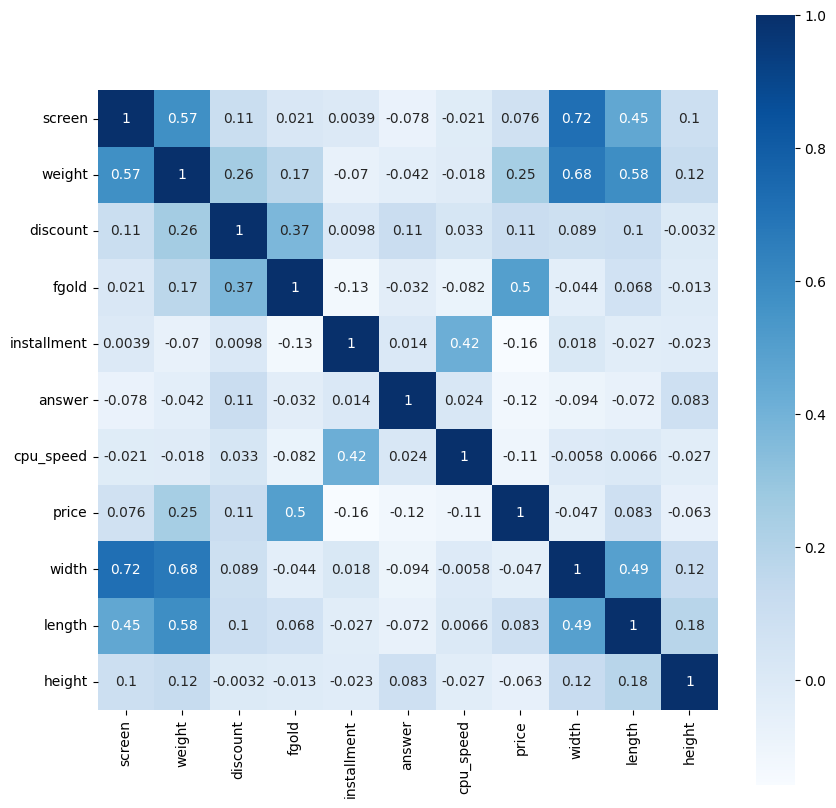

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# tinh su phu thuoc cua tung thuoc tinh
data_numeric=data.select_dtypes(include='float64')
correlation = data_numeric.corr(method='pearson')
fig = plt.figure(figsize=(10,10))
#figsize: figure size by inches
#subplot: draw mutiple plots in one figure
sns.heatmap(correlation,vmax=1,square=True,annot=True,cmap='Blues');

In [ ]:
correlation_with_price = correlation["price"]
# Sắp xếp giảm dần và lấy top 10
top_correlated_columns = correlation_with_price.abs().sort_values(ascending=False).head(11)[1:]
# In ra top 10 cột
print("Top 10 cột có chỉ số tương quan cao nhất với giá:")
print(top_correlated_columns)

Top 10 cột có chỉ số tương quan cao nhất với giá:
RAM            0.735221
fgold          0.499884
memory         0.499830
screen_scan    0.399329
weight         0.246504
ram_track      0.172019
installment    0.157839
evaluation     0.128152
answer         0.121414
discount       0.112344
Name: price, dtype: float64


In [ ]:
# Chia dữ liệu ra làm 2 dataframe chỉ gồm các thuộc tính liên tục hoặc phân loại
data_numeric=data.select_dtypes(include='float64')
data_cate=data.select_dtypes(exclude='float64')
data_cate.info()
data_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   brand              257 non-null    object
 1   CPU                257 non-null    object
 2   RAM                257 non-null    int64 
 3   memory             257 non-null    int64 
 4   graphic card       257 non-null    object
 5   warranty           257 non-null    int64 
 6   evaluation         257 non-null    int64 
 7   star               257 non-null    int64 
 8   color              257 non-null    object
 9   cpu_branch         257 non-null    object
 10  cpu_type           257 non-null    object
 11  ram_track          257 non-null    int64 
 12  screen_tech        257 non-null    object
 13  screen_resolution  257 non-null    object
 14  screen_plate       257 non-null    object
 15  screen_scan        257 non-null    int64 
 16  keyboard_type      257 non-null    object
 1

<Figure size 1500x2000 with 0 Axes>

<Axes: >

<Axes: xlabel='screen', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of screen')

<Axes: >

<Axes: xlabel='weight', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of weight')

<Axes: >

<Axes: xlabel='discount', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of discount')

<Axes: >

<Axes: xlabel='fgold', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of fgold')

<Axes: >

<Axes: xlabel='installment', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of installment')

<Axes: >

<Axes: xlabel='answer', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of answer')

<Axes: >

<Axes: xlabel='cpu_speed', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of cpu_speed')

<Axes: >

<Axes: xlabel='price', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of price')

<Axes: >

<Axes: xlabel='width', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of width')

<Axes: >

<Axes: xlabel='length', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of length')

<Axes: >

<Axes: xlabel='height', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of height')

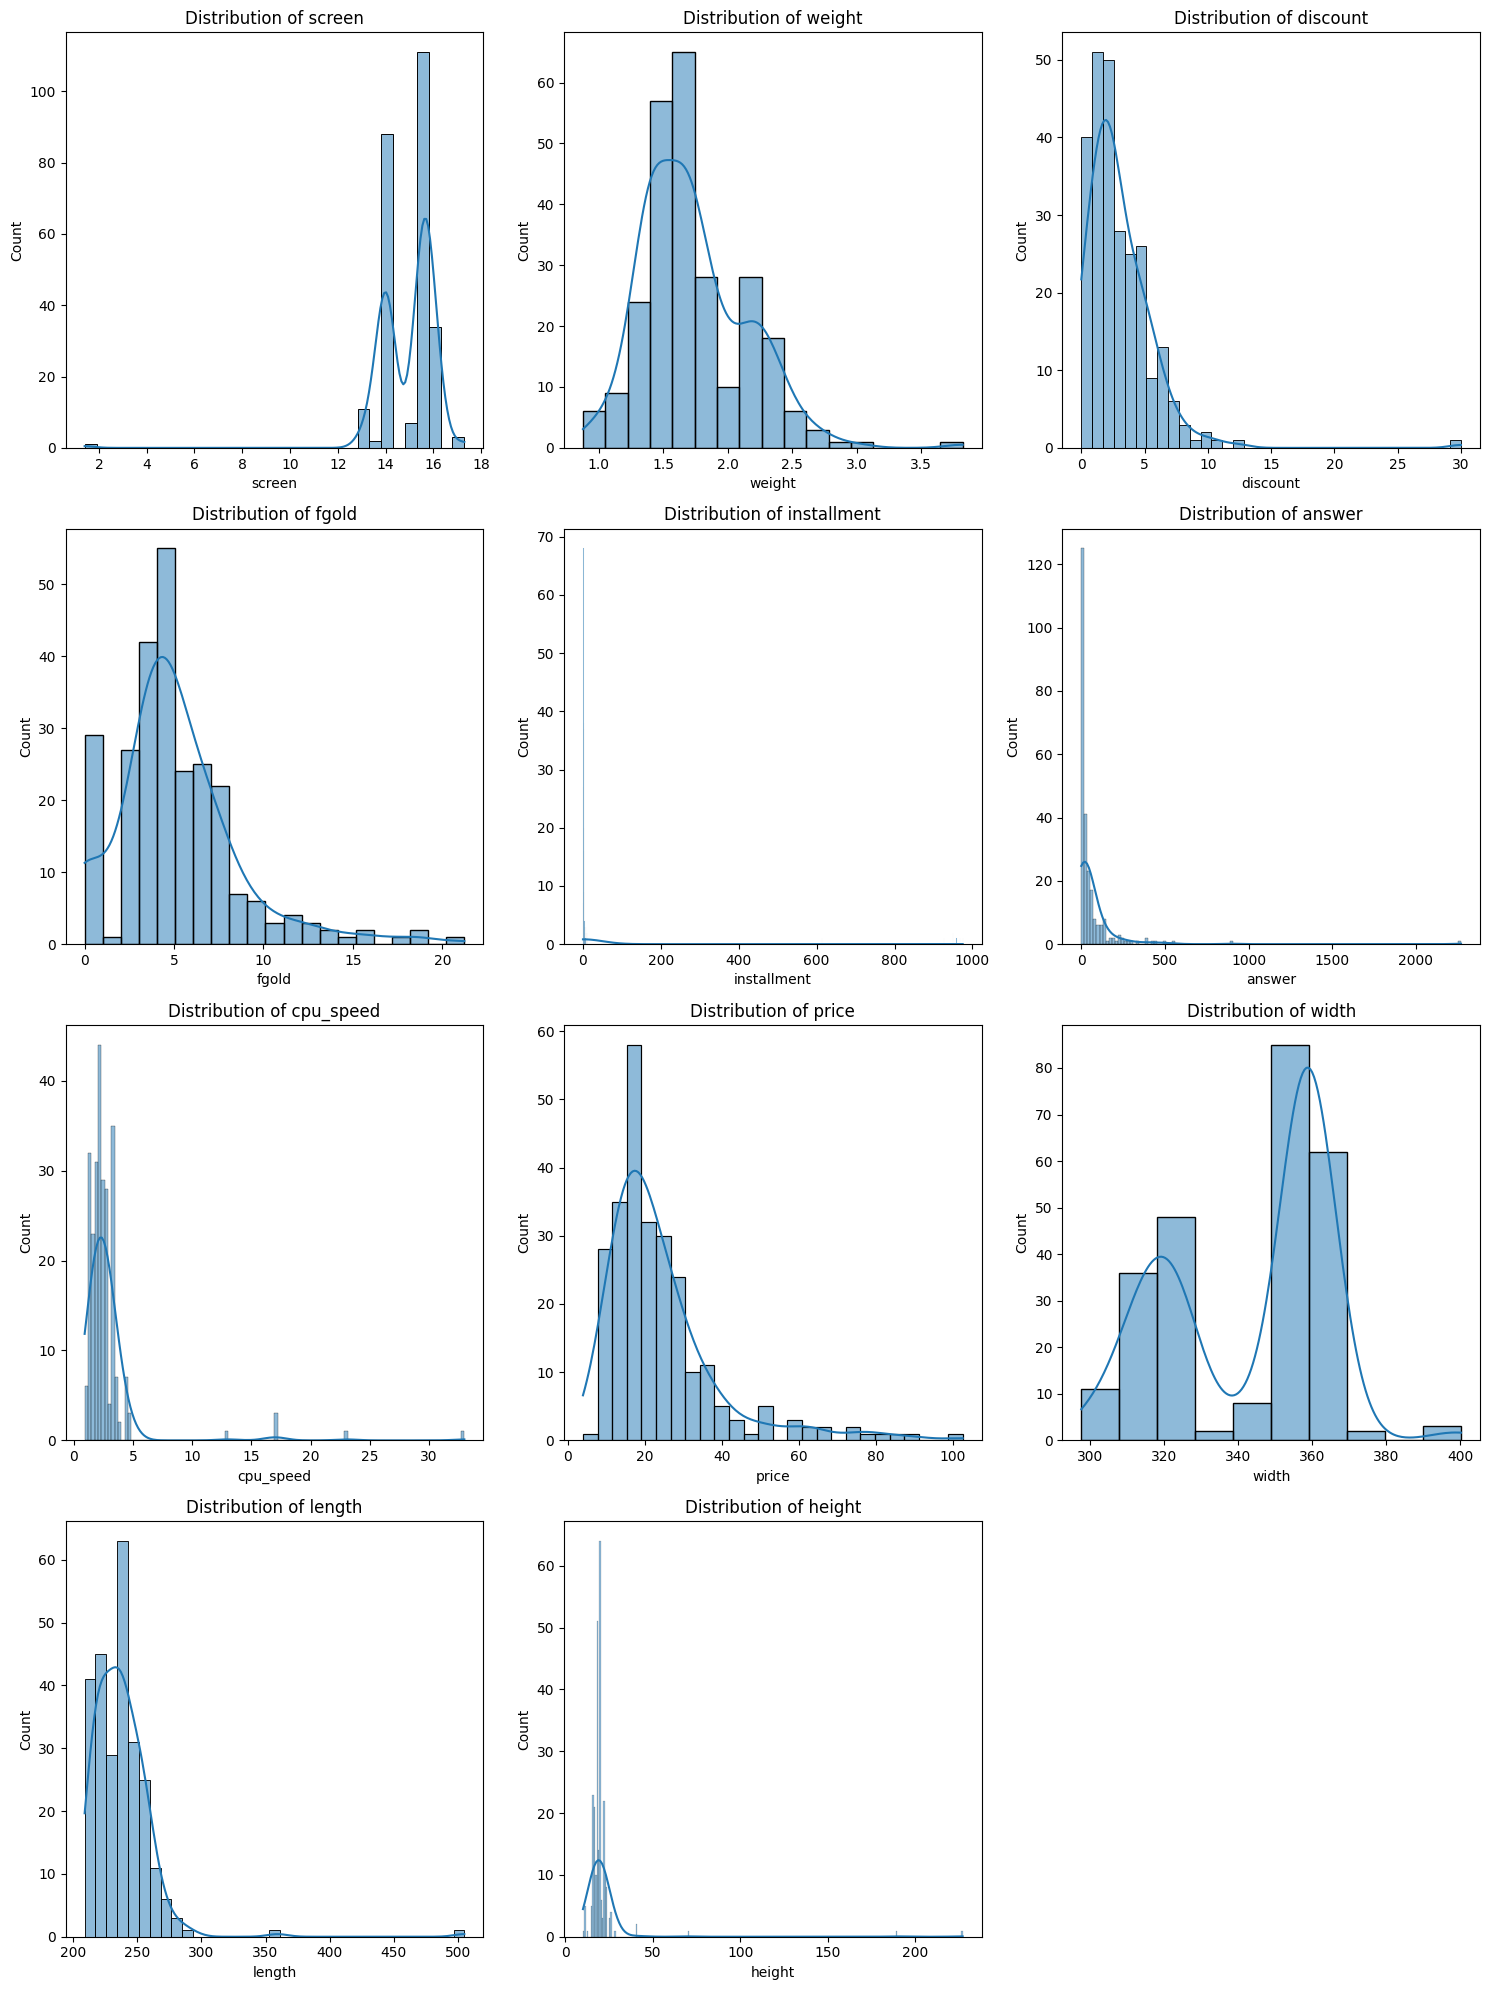

In [ ]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

feature_list = list(data_numeric.columns)
num_features = len(feature_list)
num_rows = (num_features - 1) // 3 + 1
num_cols = min(num_features, 3)

plt.figure(figsize=(15, 5 * num_rows))

for i, feature in enumerate(feature_list):
    plt.subplot(num_rows, num_cols, i+1)
    sns.histplot(data_numeric[feature], kde=True)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()

plt.show()


<Figure size 1500x2000 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, 'screen')

<Axes: >

<Axes: >

Text(0.5, 1.0, 'weight')

<Axes: >

<Axes: >

Text(0.5, 1.0, 'discount')

<Axes: >

<Axes: >

Text(0.5, 1.0, 'fgold')

<Axes: >

<Axes: >

Text(0.5, 1.0, 'installment')

<Axes: >

<Axes: >

Text(0.5, 1.0, 'answer')

<Axes: >

<Axes: >

Text(0.5, 1.0, 'cpu_speed')

<Axes: >

<Axes: >

Text(0.5, 1.0, 'price')

<Axes: >

<Axes: >

Text(0.5, 1.0, 'width')

<Axes: >

<Axes: >

Text(0.5, 1.0, 'length')

<Axes: >

<Axes: >

Text(0.5, 1.0, 'height')

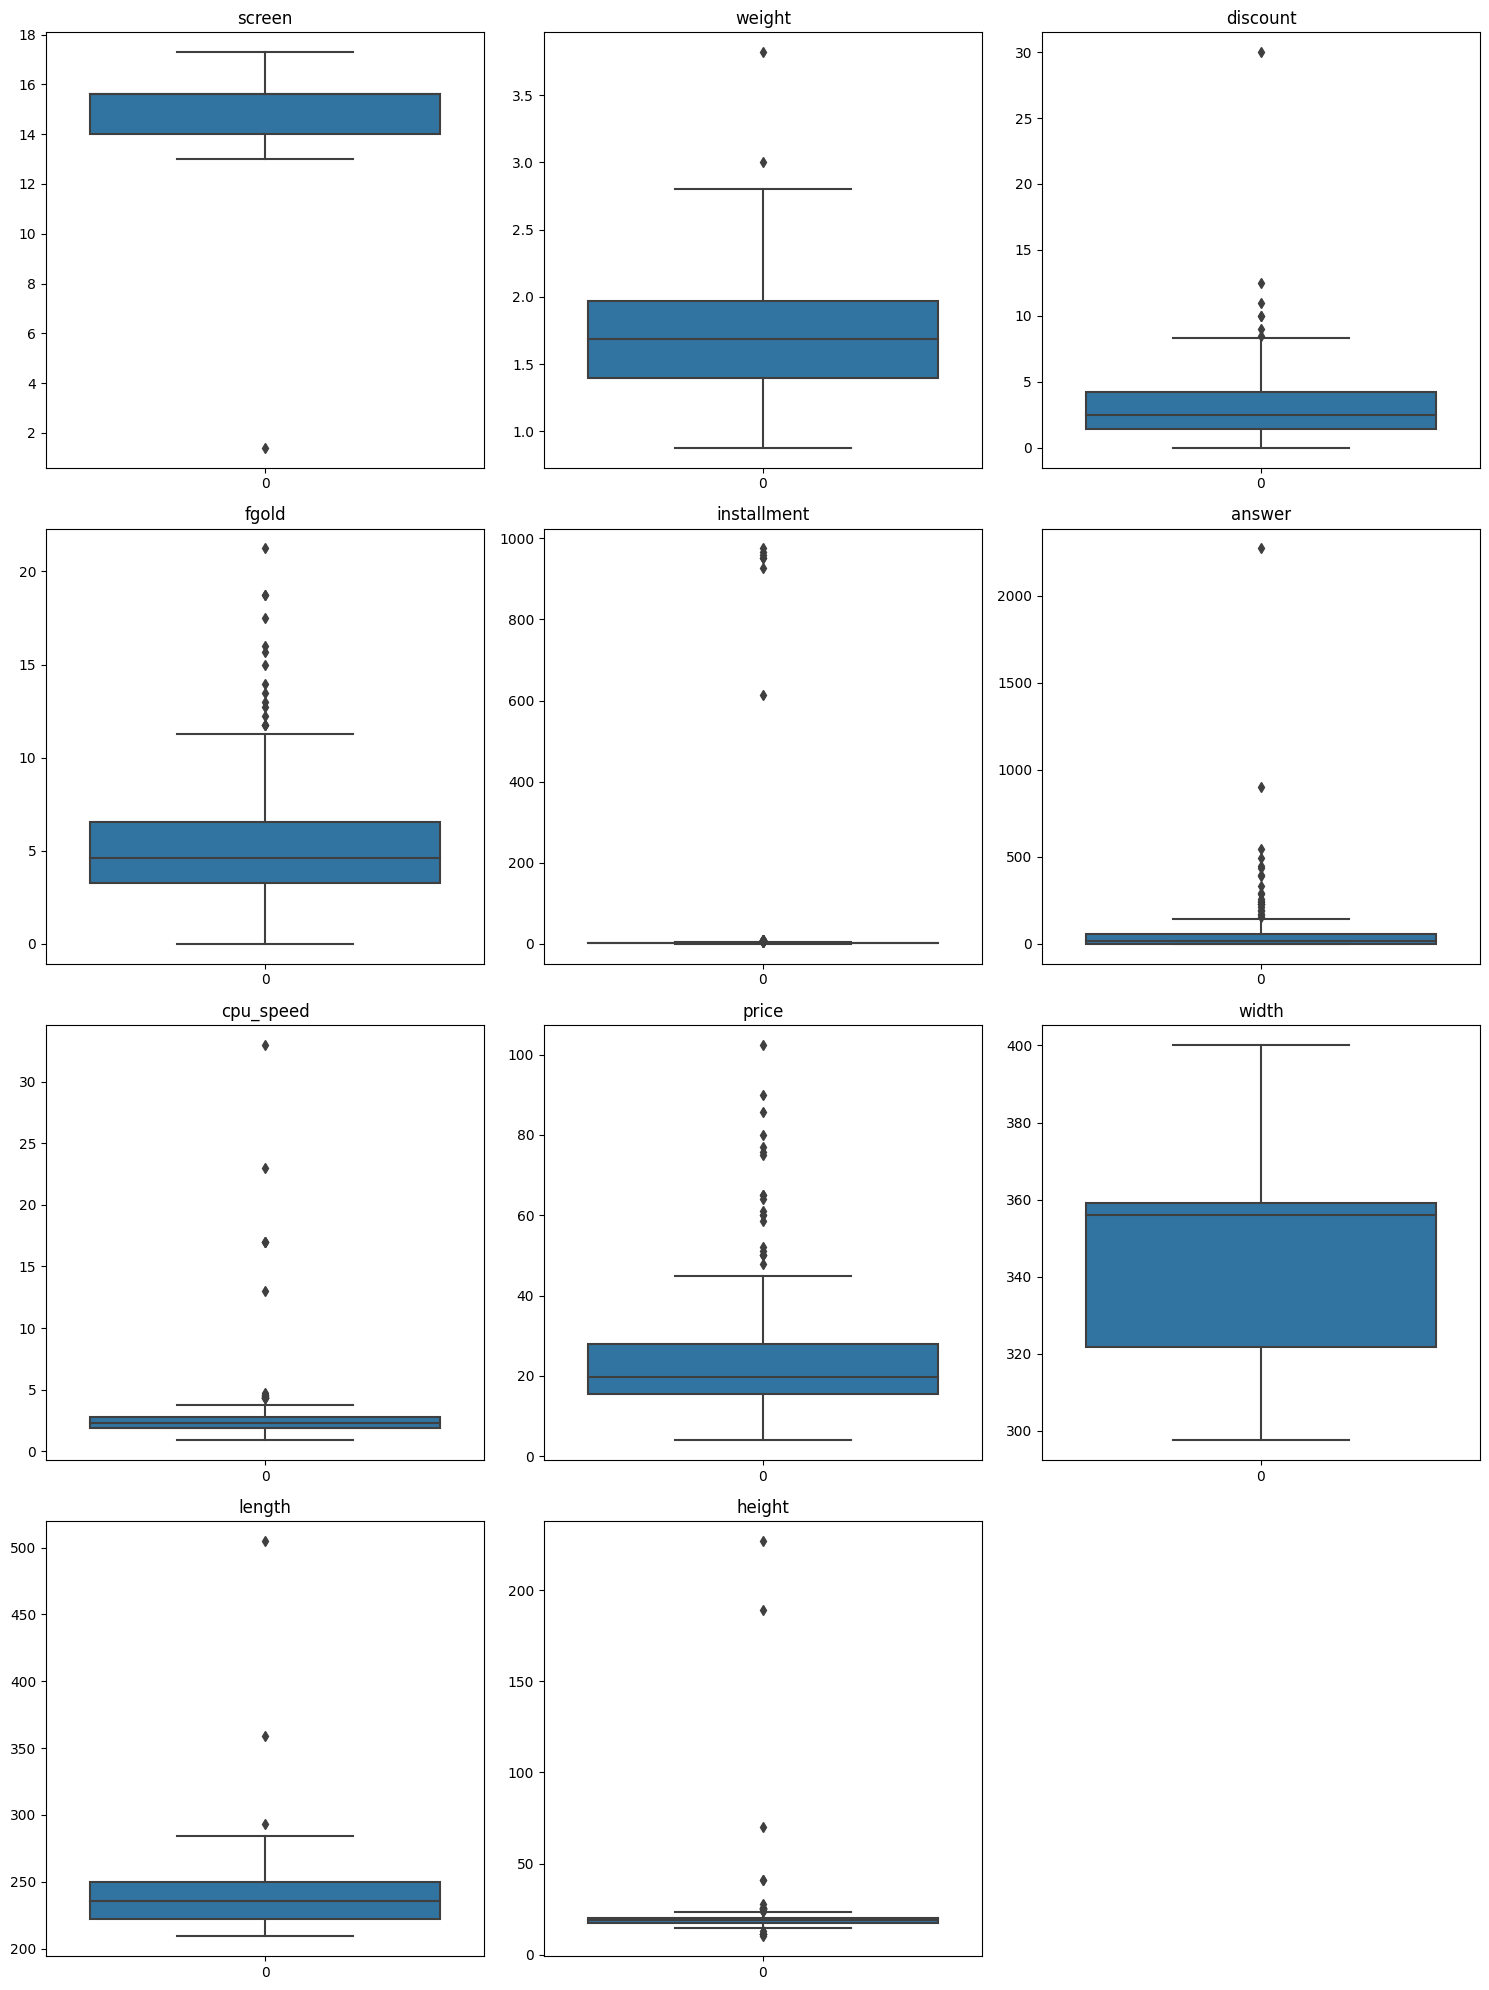

In [ ]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

feature_list = list(data_numeric.columns)
num_features = len(feature_list)
num_rows = (num_features - 1) // 3 + 1
num_cols = min(num_features, 3)

plt.figure(figsize=(15, 5 * num_rows))

for i, feature in enumerate(feature_list):
    plt.subplot(num_rows, num_cols, i+1)
    sns.boxplot(data_numeric[feature])
    plt.title(f'{feature}')

plt.tight_layout()

plt.show()


<Figure size 1500x2000 with 0 Axes>

<Axes: >

<Axes: xlabel='screen', ylabel='price'>

Text(0.5, 1.0, 'screen')

<Axes: >

<Axes: xlabel='weight', ylabel='price'>

Text(0.5, 1.0, 'weight')

<Axes: >

<Axes: xlabel='discount', ylabel='price'>

Text(0.5, 1.0, 'discount')

<Axes: >

<Axes: xlabel='fgold', ylabel='price'>

Text(0.5, 1.0, 'fgold')

<Axes: >

<Axes: xlabel='installment', ylabel='price'>

Text(0.5, 1.0, 'installment')

<Axes: >

<Axes: xlabel='answer', ylabel='price'>

Text(0.5, 1.0, 'answer')

<Axes: >

<Axes: xlabel='cpu_speed', ylabel='price'>

Text(0.5, 1.0, 'cpu_speed')

<Axes: >

<Axes: xlabel='price', ylabel='price'>

Text(0.5, 1.0, 'price')

<Axes: >

<Axes: xlabel='width', ylabel='price'>

Text(0.5, 1.0, 'width')

<Axes: >

<Axes: xlabel='length', ylabel='price'>

Text(0.5, 1.0, 'length')

<Axes: >

<Axes: xlabel='height', ylabel='price'>

Text(0.5, 1.0, 'height')

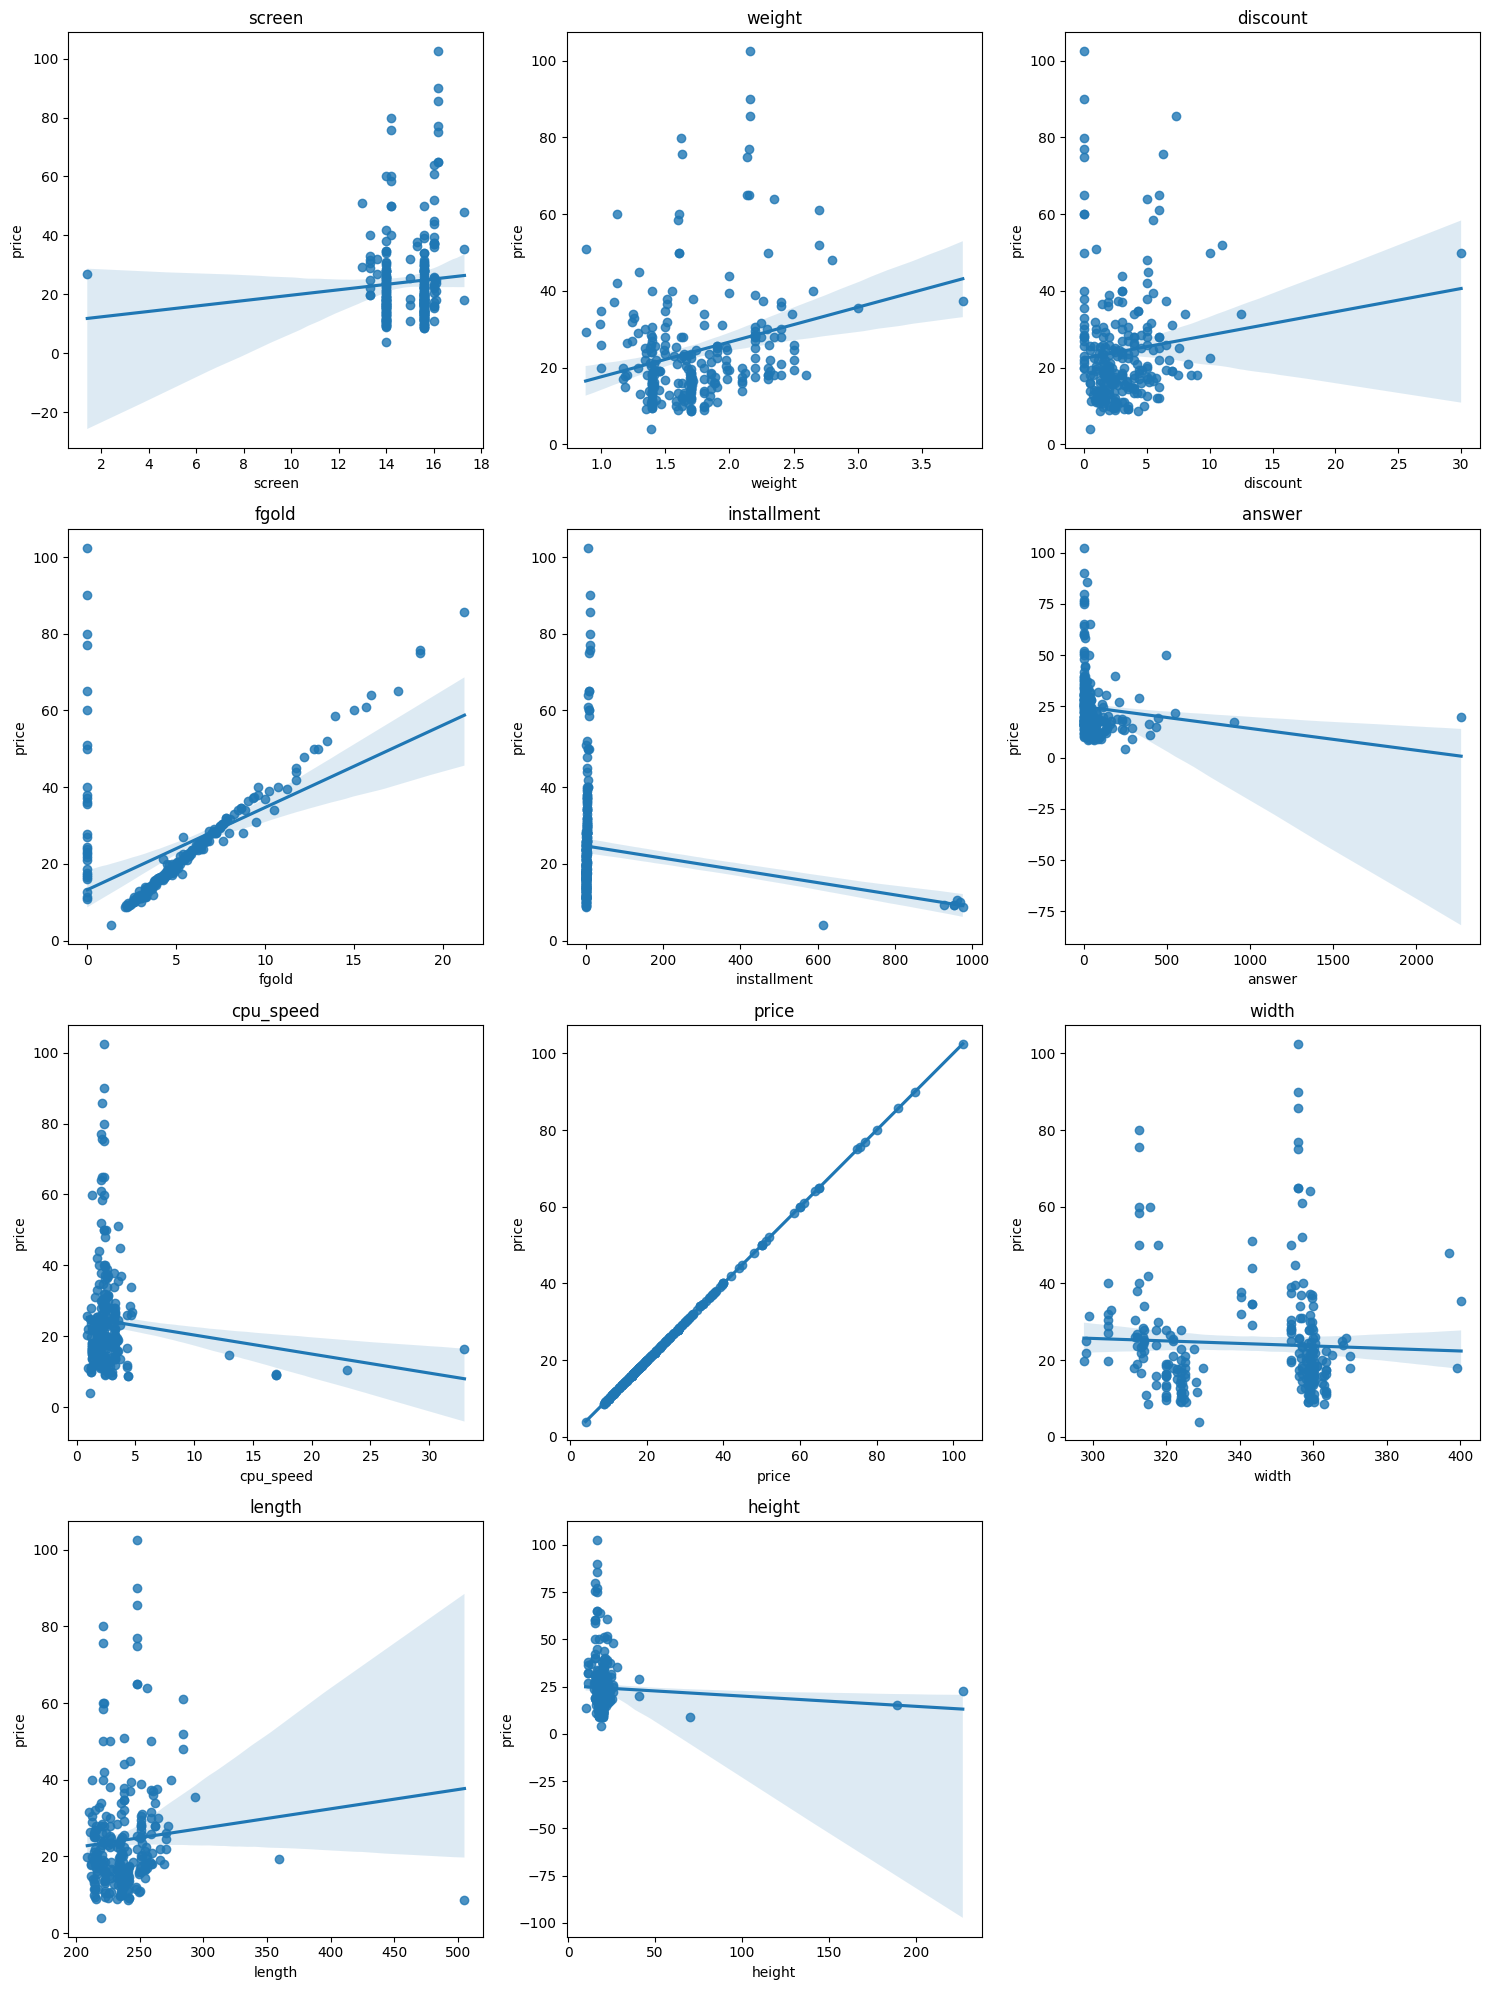

In [ ]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
feature_list = list(data_numeric.columns)

num_features = len(feature_list)
num_rows = (num_features - 1) // 3 + 1
num_cols = min(num_features, 3)
plt.figure(figsize=(15, 5 * num_rows))

for i, feature in enumerate(feature_list):
    plt.subplot(num_rows, num_cols, i+1)
    sns.regplot(x=f'{feature}', y='price',data=data)
    plt.title(f'{feature}')
plt.tight_layout()

plt.show()


<Figure size 1500x10500 with 0 Axes>

<Axes: >

<Axes: xlabel='brand', ylabel='price'>

Text(0.5, 1.0, 'Boxplot of brand')

<Axes: >

<Axes: xlabel='CPU', ylabel='price'>

Text(0.5, 1.0, 'Boxplot of CPU')

<Axes: >

<Axes: xlabel='RAM', ylabel='price'>

Text(0.5, 1.0, 'Boxplot of RAM')

<Axes: >

<Axes: xlabel='memory', ylabel='price'>

Text(0.5, 1.0, 'Boxplot of memory')

<Axes: >

<Axes: xlabel='graphic card', ylabel='price'>

Text(0.5, 1.0, 'Boxplot of graphic card')

<Axes: >

<Axes: xlabel='warranty', ylabel='price'>

Text(0.5, 1.0, 'Boxplot of warranty')

<Axes: >

<Axes: xlabel='evaluation', ylabel='price'>

Text(0.5, 1.0, 'Boxplot of evaluation')

<Axes: >

<Axes: xlabel='star', ylabel='price'>

Text(0.5, 1.0, 'Boxplot of star')

<Axes: >

<Axes: xlabel='color', ylabel='price'>

Text(0.5, 1.0, 'Boxplot of color')

<Axes: >

<Axes: xlabel='cpu_branch', ylabel='price'>

Text(0.5, 1.0, 'Boxplot of cpu_branch')

<Axes: >

<Axes: xlabel='cpu_type', ylabel='price'>

Text(0.5, 1.0, 'Boxplot of cpu_type')

<Axes: >

<Axes: xlabel='ram_track', ylabel='price'>

Text(0.5, 1.0, 'Boxplot of ram_track')

<Axes: >

<Axes: xlabel='screen_tech', ylabel='price'>

Text(0.5, 1.0, 'Boxplot of screen_tech')

<Axes: >

<Axes: xlabel='screen_resolution', ylabel='price'>

Text(0.5, 1.0, 'Boxplot of screen_resolution')

<Axes: >

<Axes: xlabel='screen_plate', ylabel='price'>

Text(0.5, 1.0, 'Boxplot of screen_plate')

<Axes: >

<Axes: xlabel='screen_scan', ylabel='price'>

Text(0.5, 1.0, 'Boxplot of screen_scan')

<Axes: >

<Axes: xlabel='keyboard_type', ylabel='price'>

Text(0.5, 1.0, 'Boxplot of keyboard_type')

<Axes: >

<Axes: xlabel='keyboard_number', ylabel='price'>

Text(0.5, 1.0, 'Boxplot of keyboard_number')

<Axes: >

<Axes: xlabel='keyboard_lamp', ylabel='price'>

Text(0.5, 1.0, 'Boxplot of keyboard_lamp')

<Axes: >

<Axes: xlabel='os', ylabel='price'>

Text(0.5, 1.0, 'Boxplot of os')

<Axes: >

<Axes: xlabel='graphic_brand', ylabel='price'>

Text(0.5, 1.0, 'Boxplot of graphic_brand')

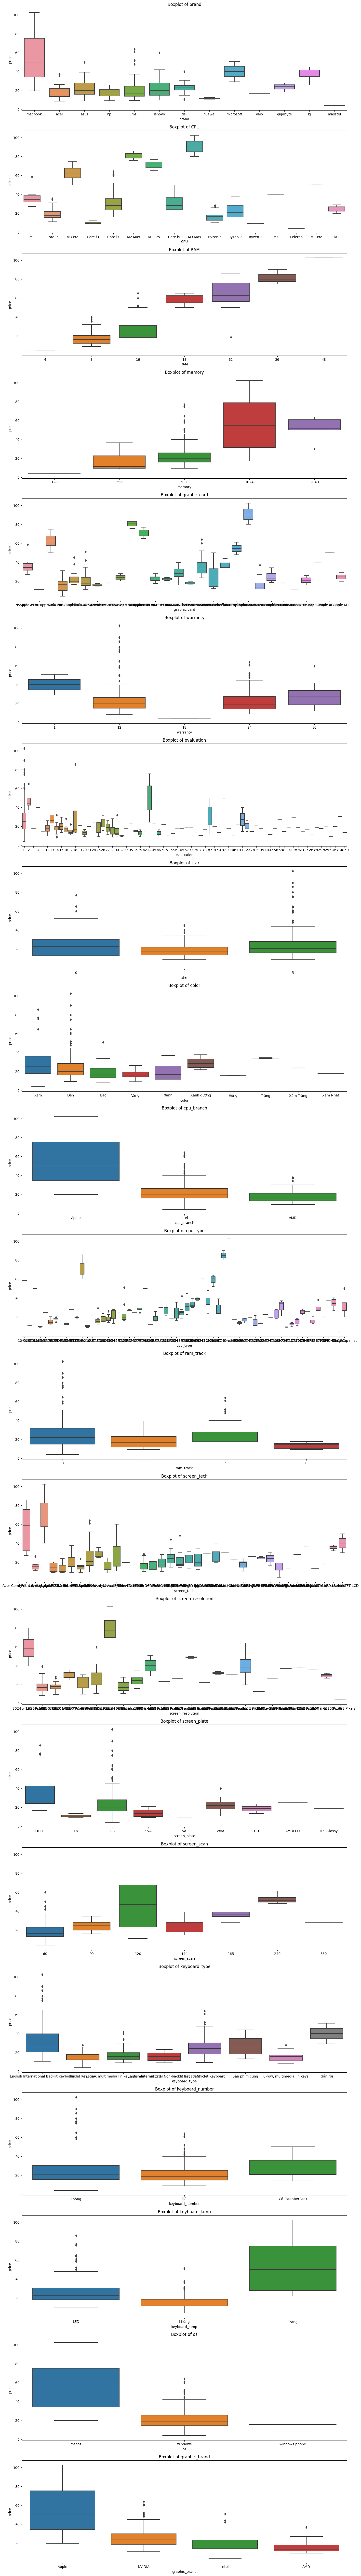

In [ ]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

feature_list = list(data_cate.columns)
plt.figure(figsize=(15, 5 * len(feature_list)))

for i, feature in enumerate(feature_list):
    plt.subplot(len(feature_list), 1, i+1)
    sns.boxplot(x=feature, y='price', data=data)
    plt.title(f'Boxplot of {feature}')

plt.tight_layout()

plt.show()


<Figure size 1500x10500 with 0 Axes>

<Axes: >

<Axes: xlabel='brand', ylabel='count'>

Text(0.5, 1.0, 'Boxplot of brand')

<Axes: >

<Axes: xlabel='CPU', ylabel='count'>

Text(0.5, 1.0, 'Boxplot of CPU')

<Axes: >

<Axes: xlabel='RAM', ylabel='count'>

Text(0.5, 1.0, 'Boxplot of RAM')

<Axes: >

<Axes: xlabel='memory', ylabel='count'>

Text(0.5, 1.0, 'Boxplot of memory')

<Axes: >

<Axes: xlabel='graphic card', ylabel='count'>

Text(0.5, 1.0, 'Boxplot of graphic card')

<Axes: >

<Axes: xlabel='warranty', ylabel='count'>

Text(0.5, 1.0, 'Boxplot of warranty')

<Axes: >

<Axes: xlabel='evaluation', ylabel='count'>

Text(0.5, 1.0, 'Boxplot of evaluation')

<Axes: >

<Axes: xlabel='star', ylabel='count'>

Text(0.5, 1.0, 'Boxplot of star')

<Axes: >

<Axes: xlabel='color', ylabel='count'>

Text(0.5, 1.0, 'Boxplot of color')

<Axes: >

<Axes: xlabel='cpu_branch', ylabel='count'>

Text(0.5, 1.0, 'Boxplot of cpu_branch')

<Axes: >

<Axes: xlabel='cpu_type', ylabel='count'>

Text(0.5, 1.0, 'Boxplot of cpu_type')

<Axes: >

<Axes: xlabel='ram_track', ylabel='count'>

Text(0.5, 1.0, 'Boxplot of ram_track')

<Axes: >

<Axes: xlabel='screen_tech', ylabel='count'>

Text(0.5, 1.0, 'Boxplot of screen_tech')

<Axes: >

<Axes: xlabel='screen_resolution', ylabel='count'>

Text(0.5, 1.0, 'Boxplot of screen_resolution')

<Axes: >

<Axes: xlabel='screen_plate', ylabel='count'>

Text(0.5, 1.0, 'Boxplot of screen_plate')

<Axes: >

<Axes: xlabel='screen_scan', ylabel='count'>

Text(0.5, 1.0, 'Boxplot of screen_scan')

<Axes: >

<Axes: xlabel='keyboard_type', ylabel='count'>

Text(0.5, 1.0, 'Boxplot of keyboard_type')

<Axes: >

<Axes: xlabel='keyboard_number', ylabel='count'>

Text(0.5, 1.0, 'Boxplot of keyboard_number')

<Axes: >

<Axes: xlabel='keyboard_lamp', ylabel='count'>

Text(0.5, 1.0, 'Boxplot of keyboard_lamp')

<Axes: >

<Axes: xlabel='os', ylabel='count'>

Text(0.5, 1.0, 'Boxplot of os')

<Axes: >

<Axes: xlabel='graphic_brand', ylabel='count'>

Text(0.5, 1.0, 'Boxplot of graphic_brand')

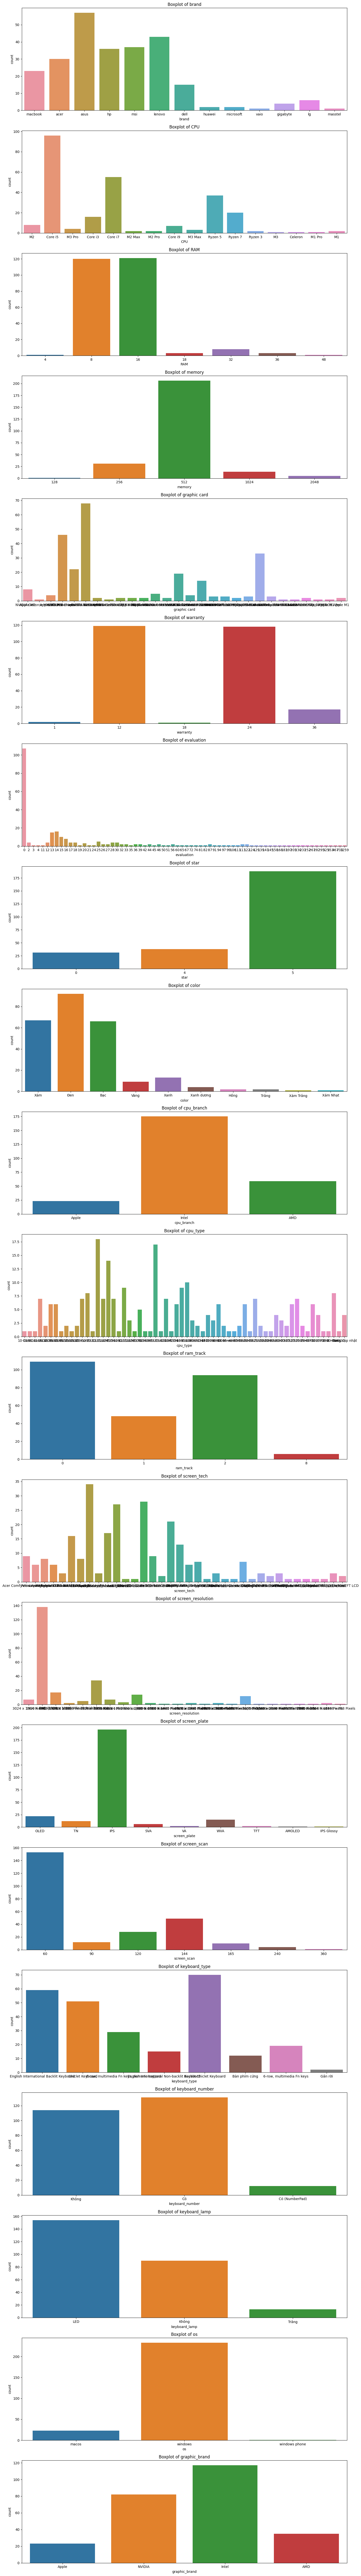

In [ ]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

feature_list = list(data_cate.columns)
plt.figure(figsize=(15, 5 * len(feature_list)))

for i, feature in enumerate(feature_list):
    plt.subplot(len(feature_list), 1, i+1)
    sns.countplot(x=data[feature])
    plt.title(f'Boxplot of {feature}')

plt.tight_layout()

plt.show()


(array([237.,  11.,   6.,   1.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([   0. ,  125.9,  251.8,  377.7,  503.6,  629.5,  755.4,  881.3,
        1007.2, 1133.1, 1259. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Phân phối Đánh giá')

Text(0.5, 0, 'Đánh giá')

Text(0, 0.5, 'Số lượng')

(array([ 31.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  38., 188.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Phân phối số sao của Người dùng')

Text(0.5, 0, 'Số Sao')

Text(0, 0.5, 'Số lượng')

(array([240.,  13.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([   0. ,  227.1,  454.2,  681.3,  908.4, 1135.5, 1362.6, 1589.7,
        1816.8, 2043.9, 2271. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Phân phối Số lượng câu trả lời')

Text(0.5, 0, 'Số lượng answer')

Text(0, 0.5, 'Số lượng')

Text(0.5, 1.0, 'Tương quan Đánh giá và Giá')

Text(0.5, 0, 'Đánh giá')

Text(0, 0.5, 'Giá')

Text(0.5, 1.0, 'Tương quan số sao và Giá')

Text(0.5, 0, 'Số Sao')

Text(0, 0.5, 'Giá')

Text(0.5, 1.0, 'Tương quan Số lượng câu trả lời và Giá')

Text(0.5, 0, 'Số lượng answer')

Text(0, 0.5, 'Giá')

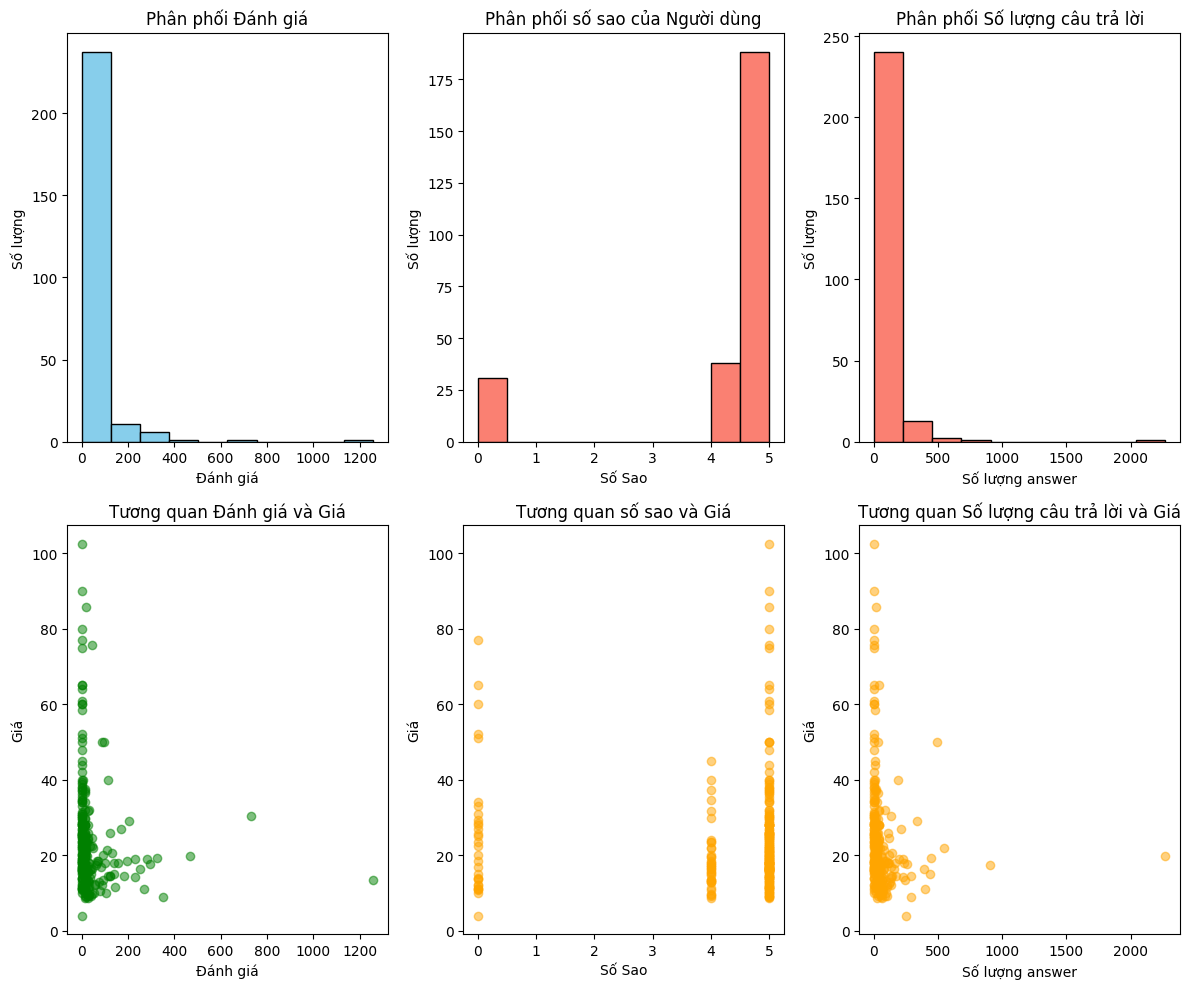

In [ ]:
data_target_viewer=data[['evaluation','answer','star','price']]

# Phân tích đánh giá và đánh giá của người dùng
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))

# Biểu đồ phân phối đánh giá
axes[0, 0].hist(data_target_viewer['evaluation'], bins=10, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Phân phối Đánh giá')
axes[0, 0].set_xlabel('Đánh giá')
axes[0, 0].set_ylabel('Số lượng')

# Biểu đồ phân phối đánh giá của người dùng
axes[0, 1].hist(data_target_viewer['star'], bins=10, color='salmon', edgecolor='black')
axes[0, 1].set_title('Phân phối số sao của Người dùng')
axes[0, 1].set_xlabel('Số Sao')
axes[0, 1].set_ylabel('Số lượng')
# Biểu đồ phân phối đánh giá của người dùng
axes[0, 2].hist(data_target_viewer['answer'], bins=10, color='salmon', edgecolor='black')
axes[0, 2].set_title('Phân phối Số lượng câu trả lời')
axes[0, 2].set_xlabel('Số lượng answer')
axes[0, 2].set_ylabel('Số lượng')
# Biểu đồ tương quan giữa đánh giá và giá
axes[1, 0].scatter(data_target_viewer['evaluation'], data['price'], alpha=0.5, color='green')
axes[1, 0].set_title('Tương quan Đánh giá và Giá')
axes[1, 0].set_xlabel('Đánh giá')
axes[1, 0].set_ylabel('Giá')

# Biểu đồ tương quan giữa đánh giá của người dùng và giá
axes[1, 1].scatter(data_target_viewer['star'], data['price'], alpha=0.5, color='orange')
axes[1, 1].set_title('Tương quan số sao và Giá')
axes[1, 1].set_xlabel('Số Sao')
axes[1, 1].set_ylabel('Giá')
# Biểu đồ tương quan giữa đánh giá của người dùng và giá
axes[1, 2].scatter(data_target_viewer['answer'], data['price'], alpha=0.5, color='orange')
axes[1, 2].set_title('Tương quan Số lượng câu trả lời và Giá')
axes[1, 2].set_xlabel('Số lượng answer')
axes[1, 2].set_ylabel('Giá')
# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

<Axes: >

Text(0.5, 1.0, 'Tương Quan với Giá Laptop')

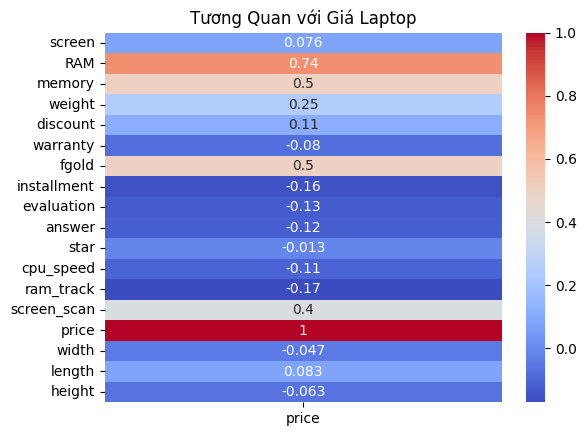

In [ ]:
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix[['price']], annot=True, cmap='coolwarm')
plt.title('Tương Quan với Giá Laptop')
plt.show()

<Axes: xlabel='screen', ylabel='price'>

Text(0.5, 1.0, 'Phân Phối Giá theo screen Laptop')

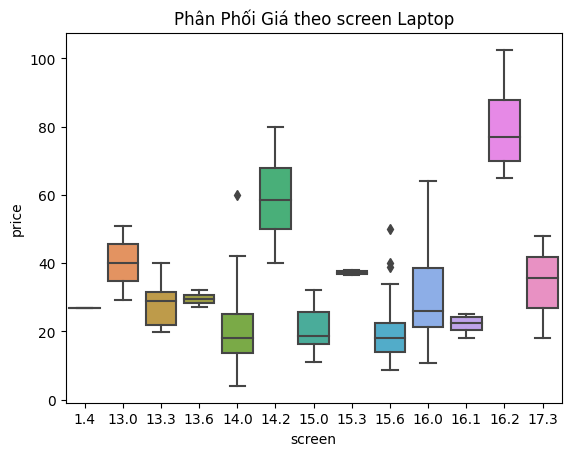

<Axes: xlabel='weight', ylabel='price'>

Text(0.5, 1.0, 'Phân Phối Giá theo weight Laptop')

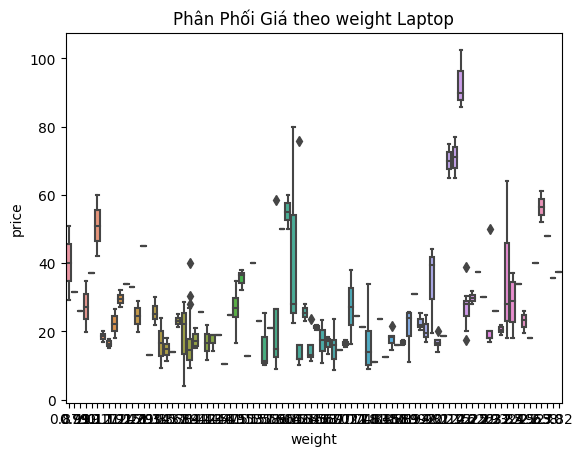

<Axes: xlabel='discount', ylabel='price'>

Text(0.5, 1.0, 'Phân Phối Giá theo discount Laptop')

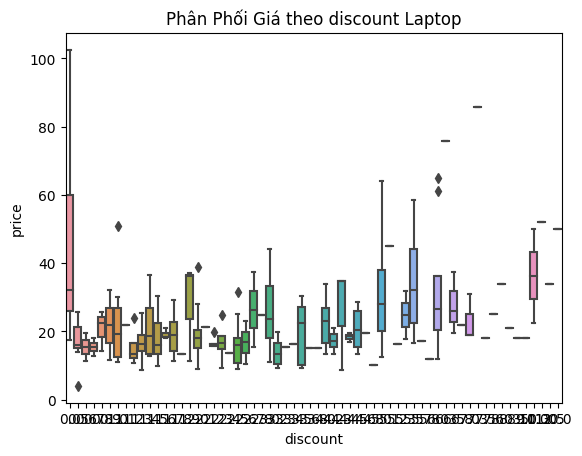

<Axes: xlabel='fgold', ylabel='price'>

Text(0.5, 1.0, 'Phân Phối Giá theo fgold Laptop')

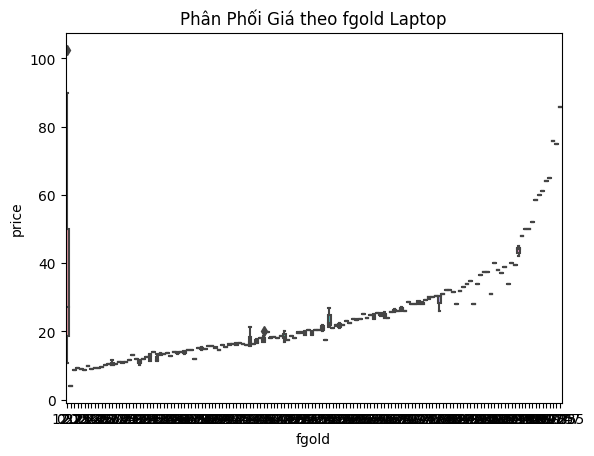

<Axes: xlabel='installment', ylabel='price'>

Text(0.5, 1.0, 'Phân Phối Giá theo installment Laptop')

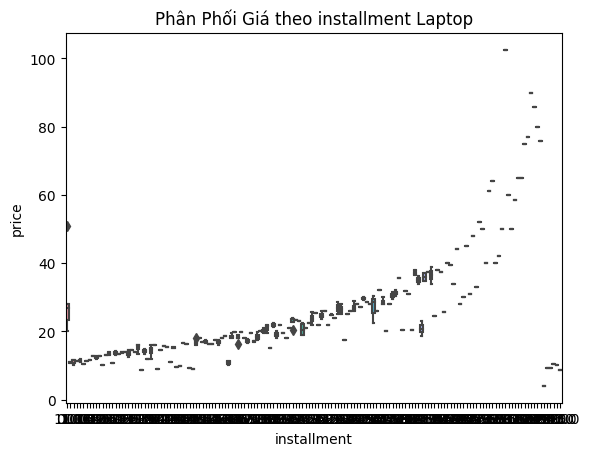

<Axes: xlabel='answer', ylabel='price'>

Text(0.5, 1.0, 'Phân Phối Giá theo answer Laptop')

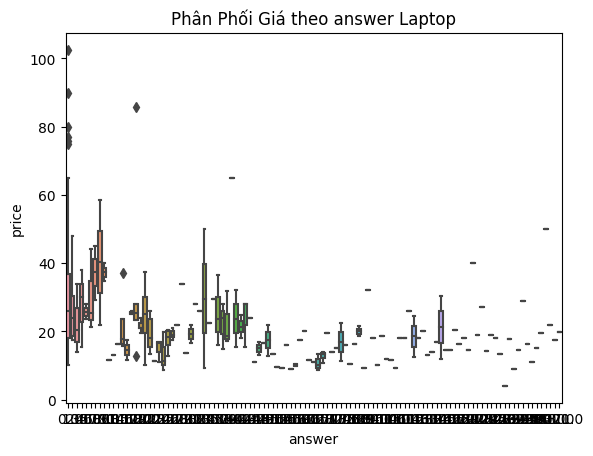

<Axes: xlabel='cpu_speed', ylabel='price'>

Text(0.5, 1.0, 'Phân Phối Giá theo cpu_speed Laptop')

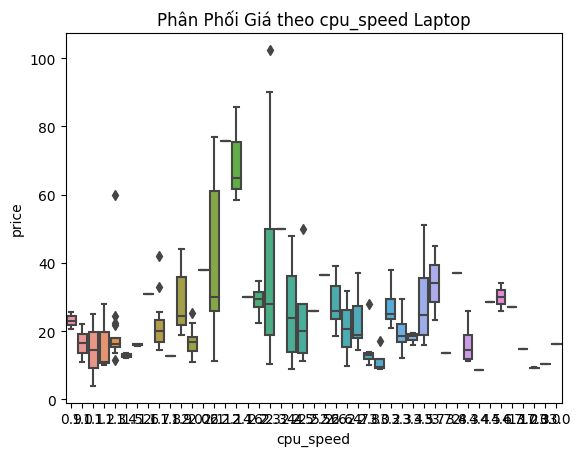

<Axes: xlabel='price', ylabel='price'>

Text(0.5, 1.0, 'Phân Phối Giá theo price Laptop')

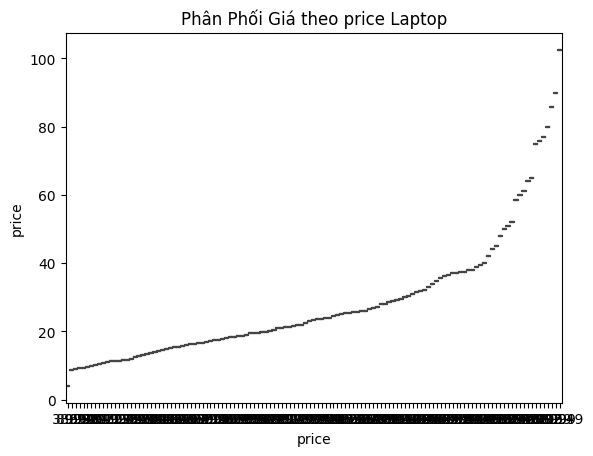

<Axes: xlabel='width', ylabel='price'>

Text(0.5, 1.0, 'Phân Phối Giá theo width Laptop')

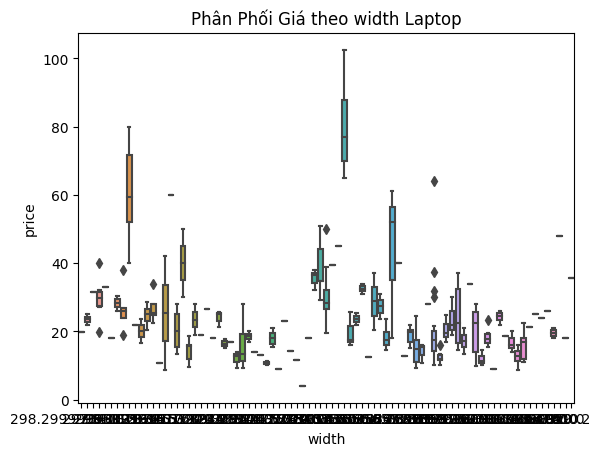

<Axes: xlabel='length', ylabel='price'>

Text(0.5, 1.0, 'Phân Phối Giá theo length Laptop')

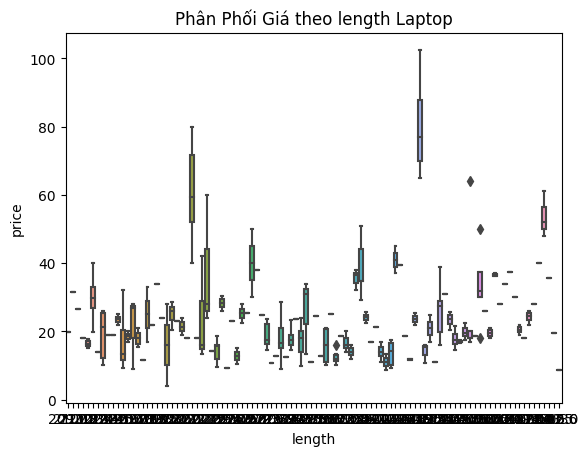

<Axes: xlabel='height', ylabel='price'>

Text(0.5, 1.0, 'Phân Phối Giá theo height Laptop')

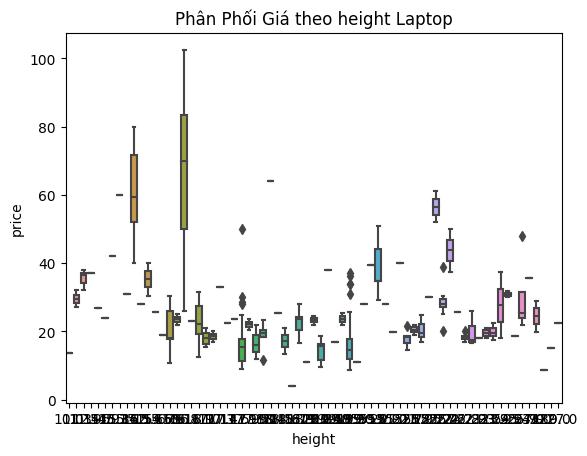

In [ ]:

for column in data_numeric.columns:
    # Ví dụ với cột 'branch'
   sns.boxplot(x=column, y='price', data=data)
   plt.title(f'Phân Phối Giá theo {column} Laptop')
   plt.show()

In [ ]:
px.box(data, x='brand', y='price', title='Boxplot between Brand and Price', width=1000, height=700).show()

<Axes: xlabel='brand', ylabel='count'>

<Axes: xlabel='brand', ylabel='price'>

Text(0.5, 0, 'Hãng')

Text(0, 0.5, 'Số lượng đánh giá')

Text(0, 0.5, 'Giá')

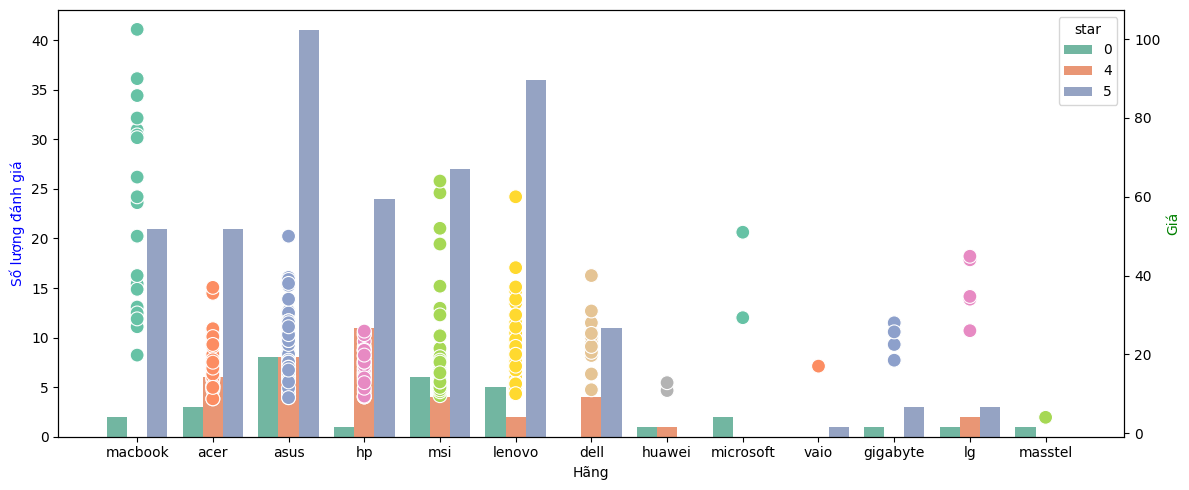

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(12, 5))

sns.countplot(x='brand', hue='star', data=data, palette='Set2', ax=ax1)

ax2 = ax1.twinx()
sns.scatterplot(x='brand', y='price', data=data, hue='brand', palette='Set2', s=100, ax=ax2, legend=False)

ax1.set_xlabel('Hãng')
ax1.set_ylabel('Số lượng đánh giá', color='b')
ax2.set_ylabel('Giá', color='g')

ax2.yaxis.grid(False)
plt.tight_layout()
plt.show()


<Axes: xlabel='graphic_brand', ylabel='price'>

Text(0, 0.5, 'Giá')

Text(0.5, 0, 'Hãng card')

<Axes: xlabel='Hãng card', ylabel='Giá'>

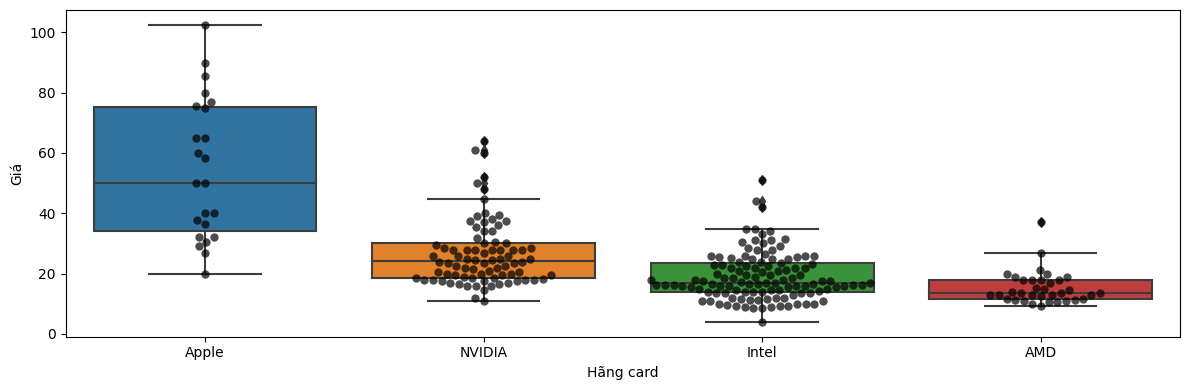

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 4))

# Boxplot
sns.boxplot(x=data["graphic_brand"], y=data['price'], ax=ax)
ax.set_ylabel('Giá')
ax.set_xlabel('Hãng card')
sns.swarmplot(x=data["graphic_brand"], y=data['price'], color='black', alpha=0.7, size=6, ax=ax)

plt.tight_layout()
plt.show()


# plt.title('Biểu đồ hộp thể hiện tên thương hiệu graphic  và giá cả laptop')

<Figure size 1200x400 with 0 Axes>

<Axes: xlabel='price', ylabel='CPU'>

Text(0.5, 0, 'Giá')

Text(0, 0.5, 'Loại CPU')

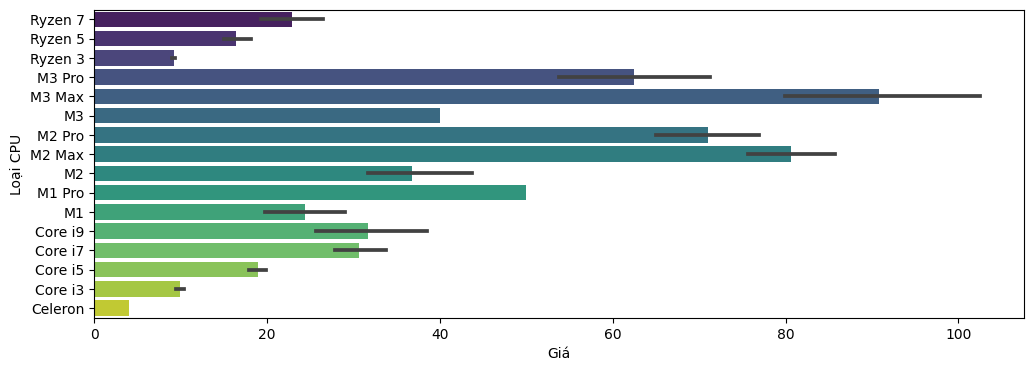

In [ ]:
plt.figure(figsize=(12, 4))
data = data.sort_values(by='CPU', ascending=False)
sns.barplot(x='price', y='CPU', data=data, palette='viridis')

plt.xlabel('Giá')
plt.ylabel('Loại CPU')
# plt.title('Biểu đồ Bar Plot: Giá cả theo loại CPU')
plt.show()

<Figure size 1200x400 with 0 Axes>

Text(0.5, 36.72222222222221, 'Loại screen')

Text(37.722222222222214, 0.5, 'Gía')

<Figure size 1200x400 with 0 Axes>

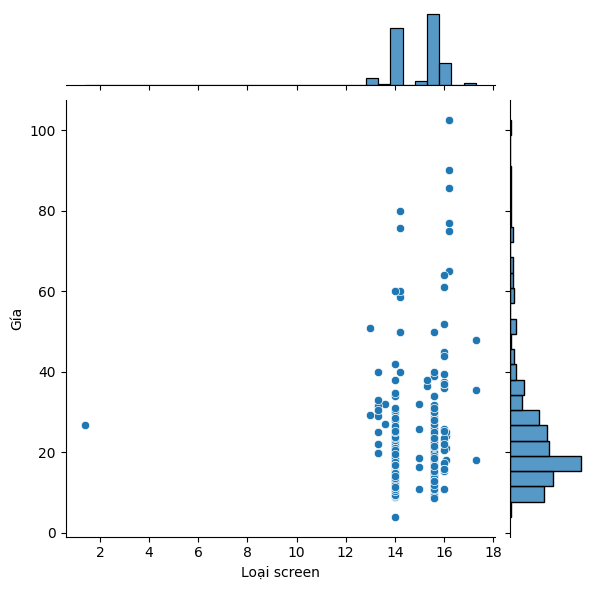

In [ ]:
plt.figure(figsize=(12, 4))
data = data.sort_values(by='screen', ascending=False)
sns.jointplot(x='screen', y='price', data=data)

plt.xlabel('Loại screen')
plt.ylabel('Gía')
# plt.title('Biểu đồ Bar Plot: Giá cả theo loại screen')
plt.show()

<Figure size 500x500 with 0 Axes>

Text(0.5, 0, 'Loại memory')

Text(0, 0.5, 'Giá')

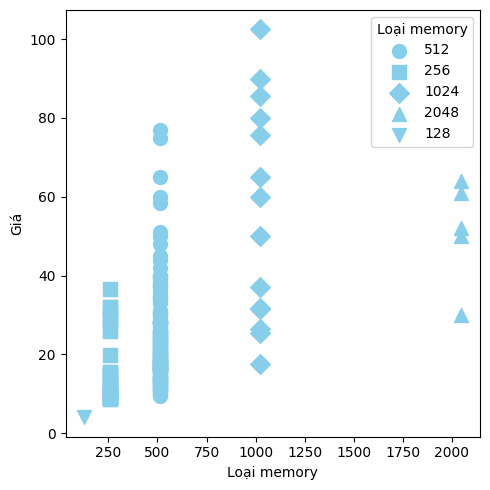

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Vẽ biểu đồ regplot với scatter=False
plt.figure(figsize=(5, 5))
# sns.regplot(x='memory', y='price', data=data, scatter_kws={'color': 'skyblue'}, line_kws={'color': 'orange'})

# Thêm ký hiệu cho từng loại memory
markers = ['o', 's', 'D', '^', 'v']
unique_memory_types = data['memory'].unique()
for i, memory_type in enumerate(unique_memory_types):
    subset = data[data['memory'] == memory_type]
    marker_index = i % len(markers)
    plt.scatter(subset['memory'], subset['price'], marker=markers[marker_index], label=memory_type, color='skyblue', s=100)

# Đặt nhan đề và tên trục
plt.xlabel('Loại memory')
plt.ylabel('Giá')
# plt.title('Mối quan hệ giữa loại memory và giá')

# Hiển thị chú thích (legend)
plt.legend(title='Loại memory')

plt.tight_layout()
plt.show()


# **4. Xây dựng mô hình**

**Prepare data**

In [ ]:
data=pd.read_csv('tidy_data.csv')
data['screen']=data['screen'].astype('category')

In [ ]:
data.head()

brand screen      CPU  RAM  memory              graphic card  weight  discount  warranty  \
0  macbook  14.2   M2       32   512     Apple M2                  1.60    5.5       12         
1  acer     15.6   Core i5  8    512     NVIDIA GeForce MX330 2GB  1.90    3.0       12         
2  macbook  14.2   M3 Pro   18   512     Apple M3 Pro              1.61    0.0       12         
3  asus     14.0   Core i3  8    256     Intel UHD Graphics        1.60    2.0       24         
4  asus     15.6   Core i3  8    256     Intel UHD Graphics        1.80    2.0       24         

    fgold  installment  evaluation  answer  star color cpu_branch cpu_type  cpu_speed  ram_track  \
0  13.970  8.586        0           7.0     5     Xám   Apple      10-Core  2.14       0           
1  2.997   1.056        267         395.0   5     Đen   Intel      1035G1   1.00       1           
2  0.000   6.701        0           0.0     5     Đen   Apple      11-core  2.30       0           
3  2.282   1.417        353         289.0   5     Bạc   Intel      1115G4   3.00       0           
4  2.997   1.618        106         94.0    5     Bạc   Intel      1115G4   3.00       1           

                             screen_tech   screen_resolution screen_plate  screen_scan  \
0  Retina                                 3024 x 1964 Pixels  OLED         120           
1  Acer ComfyView Anti-glare LED-backlit  1920 x 1080 Pixels  TN           60            
2  Liquid Retina XDR                      3024 x 1964 Pixels  IPS          120           
3  Anti-glare LED-backlit                 1920 x 1080 Pixels  TN           60            
4  Anti-glare LED-backlit                 1920 x 1080 Pixels  IPS          60            

                            keyboard_type keyboard_number keyboard_lamp       os  price  width  \
0  English International Backlit Keyboard  Không           LED           macos    58.49  312.6   
1  Chiclet Keyboard                        Không           Không         windows  10.99  363.4   
2  English International Backlit Keyboard  Không           Trắng         macos    49.99  312.6   
3  Chiclet Keyboard                        Không           Không         windows  8.99   325.4   
4  Chiclet Keyboard                        Có              Không         windows  9.99   359.0   

   length  height graphic_brand  
0  221.2   15.50   Apple         
1  250.5   19.95   NVIDIA        
2  221.2   15.50   Apple         
3  216.0   19.90   Intel         
4  235.0   17.90   Intel

# **a) Feature selection**

In [ ]:
import pandas as pd
from scipy.stats import f_oneway, chi2_contingency
import pandas as pd
from scipy.stats import pearsonr
import scipy.stats as stats

# Chia DataFrame thành hai phần: numeric và category
numeric_cols = data.select_dtypes(include=['float64']).columns
category_cols = data.select_dtypes(exclude=['float64']).columns
# data=pd.get_dummies(data, columns=category_cols, drop_first=True)

numeric_pearson_data = {'Column': [], 'Correlation': [], 'p-value': []}
for col in numeric_cols:
    if col != 'price':
        correlation, p_value = pearsonr(data[col], data['price'])
        if p_value < 0.05:  # Kiểm tra ngưỡng p-value
            numeric_pearson_data['Column'].append(col)
            numeric_pearson_data['Correlation'].append(correlation)
            numeric_pearson_data['p-value'].append(p_value)

numeric_pearson_data = pd.DataFrame(numeric_pearson_data)

category_anova_data = {'Column': [], 'F-score': [], 'p-value': []}
for col in category_cols:
    # stat, p_value = f_oneway(data[col], data['price'])
    stat, p_value = stats.f_oneway(*[values for group, values in data.groupby(col)['price']])
    if p_value<0.05:
      category_anova_data['Column'].append(col)
      category_anova_data['F-score'].append(stat)
      category_anova_data['p-value'].append(p_value)

category_anova_data = pd.DataFrame(category_anova_data)

sorted_category_anova_data = category_anova_data.sort_values(by='F-score', ascending=False)
sorted_numeric_pearson_data = numeric_pearson_data.sort_values(by='Correlation', ascending=False)


In [ ]:
sorted_numeric_pearson_data.reset_index().drop('index',axis=1)

Column  Correlation       p-value
0  fgold        0.499884     1.183923e-17
1  weight       0.246504     6.488505e-05
2  installment -0.157839     1.127941e-02

In [ ]:
sorted_category_anova_data.reset_index().drop('index',axis=1)

Column    F-score       p-value
0   cpu_branch         90.574970  2.026461e-30
1   os                 86.728928  1.951787e-29
2   graphic_brand      77.699006  1.178474e-35
3   RAM                71.928081  1.158861e-51
4   keyboard_lamp      54.013806  2.842409e-20
5   CPU                50.158279  2.782947e-65
6   screen             36.965622  3.722286e-48
7   memory             33.768842  1.469429e-22
8   screen_scan        33.192518  2.502333e-29
9   screen_resolution  31.680741  7.271777e-59
10  cpu_type           29.089559  3.763955e-71
11  graphic card       28.124741  4.753457e-58
12  brand              17.812505  2.734885e-27
13  keyboard_type      12.930871  3.587290e-14
14  screen_tech        8.556641   2.017862e-25
15  ram_track          5.946924   6.208116e-04
16  keyboard_number    5.408126   5.010872e-03
17  screen_plate       4.990984   9.459606e-06
18  color              2.646847   6.062084e-03
19  warranty           2.483828   4.424742e-02

# model training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# Chọn các biến từ DataFrame đã sắp xếp
selected_numeric_cols = sorted_numeric_pearson_data['Column'].tolist()
selected_category_cols = sorted_category_anova_data['Column'].tolist()
selected_cols = selected_numeric_cols + selected_category_cols+['price']
data = data[selected_cols]

# label_encoder = LabelEncoder()
# for col in data.columns:
#     if data[col].dtype=='category':
#       data[col] = label_encoder.fit_transform(data[col])

# train_data, test_data = train_test_split(data, test_size=0.2, random_state=123)
# X_train = train_data.drop('price', axis=1)
# y_train = train_data['price']

# X_test = test_data.drop('price', axis=1)
# y_test = test_data['price']

In [ ]:
# Tìm bậc tốt nhất cho mô hình
def findBestDegree(degs, X_train, X_test, y_train, y_test):
    Rsqr_cv_mean = []

    for deg in degs:
        pr = PolynomialFeatures(degree=deg, include_bias=False)
        X_train_pr = pr.fit_transform(X_train)
        X_test_pr = pr.fit_transform(X_test)

        # Huấn luyện mô hình với cross-validation
        lr = LinearRegression()
        cv_scores = cross_val_score(lr, X_train_pr, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='r2')
        mean_cv_score = np.mean(cv_scores)

        Rsqr_cv_mean.append(mean_cv_score)

    best_degree = degs[np.argmax(Rsqr_cv_mean)]
    return best_degree

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
from sklearn import preprocessing

def predict_Linear_One_Var(X_train, X_test, y_train, y_test):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    r_square = r2_score(y_test, y_pred)

    # Sử dụng cross-validation
    cv_scores = cross_val_score(lr, X_train, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='r2')
    return np.mean(cv_scores)

def predict_Linear_Multi_Var(X_train, X_test, y_train, y_test):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    r_square = r2_score(y_test, y_pred)

    # Sử dụng cross-validation
    cv_scores = cross_val_score(lr, X_train, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='r2')
    return np.mean(cv_scores)

def predict_Poly_One_Var(degs, X_train, X_test, y_train, y_test):
    best_degree = findBestDegree(degs, X_train, X_test, y_train, y_test)
    pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=best_degree, include_bias=False), LinearRegression())
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='r2')
    return np.mean(cv_scores), best_degree

def predict_Poly_Multi_Var(degs, X_train, X_test, y_train, y_test):
    best_degree = findBestDegree(degs, X_train, X_test, y_train, y_test)
    pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=best_degree, include_bias=False), LinearRegression())
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='r2')
    return np.mean(cv_scores), best_degree

# Biến đổi giá trị biến phân loại thành số
def replaceCategoricalCol(df):
    emp_df = pd.DataFrame()
    categorical_col = df.select_dtypes(include='object').columns
    for col in df.columns:
        if col in categorical_col:
            label_encoder = preprocessing.LabelEncoder()
            emp_df[f'new_{col}'] = label_encoder.fit_transform(df[col])
        else:
            emp_df[col] = df[col]
    return emp_df


In [ ]:
# Xây dựng hàm để dự đoán
def predict(df, target, df1):
  num_of_column = len(df.columns)
  order = [1,2,3,4,5]
  new_df = replaceCategoricalCol(df)
  info = []
  column = list(df.columns)
  X_train, X_test, y_train, y_test = train_test_split(new_df, df1[target], test_size=0.2,  random_state=42)
  if num_of_column == 1:
    linear_score = predict_Linear_One_Var(X_train, X_test, y_train, y_test)
    poly_score, best_degree = predict_Poly_One_Var(order,X_train, X_test, y_train, y_test)
    if linear_score > poly_score:
      info.append({'Dữ liệu dự đoán': column[0], 'Mô hình phù hợp': 'Hồi quy tuyến tính đơn biến', 'R^2 Linear đơn biến': linear_score, 'R^2 Poly đơn biến': poly_score})
    elif linear_score < poly_score:
      info.append({'Dữ liệu dự đoán': column[0], 'Mô hình phù hợp': 'Hồi quy đa thức đơn biến', 'Bậc tốt nhất': best_degree,'R^2 Poly đơn biến': poly_score, 'R^2 Linear đơn biến': linear_score})
    else:
      info.append({'Dữ liệu dự đoán': column[0], 'Mô hình phù hợp': 'Hồi quy tuyến tính đơn biến và Hồi quy đa thức đơn biến', 'Bậc tốt nhất': best_degree,'R^2': linear_score})
  else:
    linear_score = predict_Linear_Multi_Var(X_train, X_test, y_train, y_test)
    poly_score, best_degree = predict_Poly_Multi_Var(order,X_train, X_test, y_train, y_test)
    if linear_score > poly_score:
      info.append({'Dữ liệu dự đoán': column, 'Mô hình phù hợp': 'Hồi quy tuyến tính đa biến', 'R^2 Linear đa biến': linear_score, 'R^2 Poly đa biến': poly_score})
    elif linear_score < poly_score:
      info.append({'Dữ liệu dự đoán': column, 'Mô hình phù hợp': 'Hồi quy đa thức đa biến', 'Bậc tốt nhất': best_degree,'R^2 Poly đa biến': poly_score, 'R^2 Linear đa biến': linear_score})
    else:
      info.append({'Dữ liệu dự đoán': column, 'Mô hình phù hợp': 'Hồi quy tuyến tính đa biến và Hồi quy đa thức đa biến', 'Bậc tốt nhất': best_degree,'R^2': linear_score})
  return info


In [ ]:
df_6=data[['CPU','brand','screen','RAM','memory','graphic_brand']]
df_3=data[['CPU', 'RAM', 'memory']]
df_1=data[['CPU']]
df_all=data[selected_numeric_cols + selected_category_cols]

In [ ]:
result = predict(df_1, 'price', data)
for key,value in result[0].items():
  print(f'{key} : {value}')

Dữ liệu dự đoán : CPU
Mô hình phù hợp : Hồi quy đa thức đơn biến
Bậc tốt nhất : 5
R^2 Poly đơn biến : 0.45485431288060657
R^2 Linear đơn biến : -0.029105336656924986


In [ ]:
result = predict(df_3, 'price', data)
for key,value in result[0].items():
  print(f'{key} : {value}')

Dữ liệu dự đoán : ['CPU', 'RAM', 'memory']
Mô hình phù hợp : Hồi quy đa thức đa biến
Bậc tốt nhất : 2
R^2 Poly đa biến : 0.6210040548226301
R^2 Linear đa biến : 0.5363952258053204


In [ ]:
result = predict(df_6, 'price', data)
for key,value in result[0].items():
  print(f'{key} : {value}')

Dữ liệu dự đoán : ['CPU', 'brand', 'screen', 'RAM', 'memory', 'graphic_brand']
Mô hình phù hợp : Hồi quy tuyến tính đa biến
R^2 Linear đa biến : 0.5577507615697046
R^2 Poly đa biến : 0.5577507615697039


In [ ]:
result = predict(df_all, 'price', data)
for key,value in result[0].items():
  print(f'{key} : {value}')

Dữ liệu dự đoán : ['fgold', 'weight', 'installment', 'cpu_branch', 'os', 'graphic_brand', 'RAM', 'keyboard_lamp', 'CPU', 'screen', 'memory', 'screen_scan', 'screen_resolution', 'cpu_type', 'graphic card', 'brand', 'keyboard_type', 'screen_tech', 'ram_track', 'keyboard_number', 'screen_plate', 'color', 'warranty']
Mô hình phù hợp : Hồi quy tuyến tính đa biến
R^2 Linear đa biến : 0.8005888652974089
R^2 Poly đa biến : 0.8005888652974054
